In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import difflib
import re

## LOADING DATASET & QUIC VIEW ON THE DATASET

In [2]:
# Importing the Book data
books_df = pd.read_csv("C:/Users/uwicl/OneDrive/Desktop/ML Project/books.csv", sep=',',index_col="bookID")

In [3]:
# View the dataset from first 05 rows 
books_df.head(5)

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,Unnamed: 12
bookID,,,,,,,,,,,,
1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9.78044E+12,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,NaN
2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9.78044E+12,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,NaN
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9.78044E+12,eng,352,6333,244,11/1/2003,Scholastic,NaN
5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9.78044E+12,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,NaN
8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9.78044E+12,eng,2690,41428,164,9/13/2004,Scholastic,NaN


In [4]:
# View the dataset from last 5 rows
books_df.tail(3)

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,Unnamed: 12
bookID,,,,,,,,,,,,
45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9.78014E+12,eng,415,820,95,8/1/1993,Penguin Books,NaN
45639,Poor People,William T. Vollmann,3.72,0060878827,9.78006E+12,eng,434,769,139,2/27/2007,Ecco,NaN
45641,Las aventuras de Tom Sawyer,Mark Twain,3.91,8497646983,9.7885E+12,spa,272,113,12,5/28/2006,Edimat Libros,NaN


# DATA PREPARATION

In [5]:
books_df.shape

(11127, 12)

In [6]:
# Identify the datatypes for the columns
books_df.dtypes 

title                 object
authors               object
average_rating        object
isbn                  object
isbn13                object
language_code         object
  num_pages           object
ratings_count          int64
text_reviews_count     int64
publication_date      object
publisher             object
Unnamed: 12           object
dtype: object

In [7]:
# Check for null values
books_df.isna().sum() 

title                     0
authors                   0
average_rating            0
isbn                      0
isbn13                    0
language_code             0
  num_pages               0
ratings_count             0
text_reviews_count        0
publication_date          0
publisher                 0
Unnamed: 12           11123
dtype: int64

In [8]:
# Remove any leading or trailing spaces at the columns names for easy access late
books_df.columns = books_df.columns.str.strip() 

In [9]:
# Continuous variables to convert to numeric
continuousVars = ['average_rating', 'isbn13', 'num_pages', 'ratings_count', 'text_reviews_count']
for var in continuousVars:
    books_df[var] = pd.to_numeric(books_df[var],errors='coerce')

In [10]:
# Clean incorrect date value and Format the 'publication_date' as date data type
books_df.loc[books_df['publication_date']=="1/1/1900 0:00","publication_date"]

# Convert 'publication_date' to datetime
books_df['publication_date'] = pd.to_datetime(books_df['publication_date'], errors='coerce')

In [11]:
books_df.isna().sum() 

title                     0
authors                   0
average_rating            4
isbn                      0
isbn13                    1
language_code             0
num_pages                 4
ratings_count             0
text_reviews_count        0
publication_date          6
publisher                 0
Unnamed: 12           11123
dtype: int64

In [12]:
# Confirm and drop the column
if "Unnamed: 12" in books_df.columns:
    books_df = books_df.drop(["Unnamed: 12"], axis=1)
else:
    print("Column 'Unnamed: 12' not found in the DataFrame.")

In [13]:
# Checking rows with null value after transformating data types  
books_df[books_df.isna().any(axis=1)]  # Treatment of this missing value during feartures engineering step

,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
12224,Streetcar Suburbs: The Process of Growth in Bo...,Sam Bass Warner,NaN,3.58,6.748421e+08,9.78067E+12,NaN,236,61,NaT,4/20/2004
16914,The Tolkien Fan's Medieval Reader,David E. Smith (Turgon of TheOneRing.net,NaN,3.58,1.593600e+09,9.78159E+12,NaN,400,26,NaT,4/6/2004
22128,Patriots (The Coming Collapse),James Wesley,NaN,3.63,NaN,9.78156E+12,NaN,342,38,NaT,1/15/1999
31373,In Pursuit of the Proper Sinner (Inspector Lyn...,Elizabeth George,4.10,0553575104,9.780550e+12,eng,718.0,10608,295,NaT,Bantam Books
34889,Brown's Star Atlas: Showing All The Bright Sta...,Brown,NaN,0,8.517427e+08,9.78085E+12,NaN,49,0,NaT,5/1/1977
45531,Montaillou village occitan de 1294 à 1324,Emmanuel Le Roy Ladurie/Emmanuel Le Roy-Ladurie,3.96,2070323285,9.782070e+12,fre,640.0,15,2,NaT,Folio histoire


In [14]:
books_df.duplicated().any()

False

In [15]:
# Quick view on basic statistical measures of the dataset
books_df.describe()

,average_rating,isbn13,num_pages,ratings_count,text_reviews_count,publication_date
count,11123.000000,1.112600e+04,11123.000000,1.112700e+04,11127.000000,11121
mean,3.934075,9.757249e+12,336.405556,1.793649e+04,541.864474,2000-08-29 03:05:33.099541504
min,0.000000,6.748421e+08,0.000000,0.000000e+00,0.000000,1900-01-01 00:00:00
25%,3.770000,9.780350e+12,192.000000,1.040000e+02,9.000000,1998-07-17 00:00:00
50%,3.960000,9.780580e+12,299.000000,7.450000e+02,47.000000,2003-03-01 00:00:00
75%,4.140000,9.780870e+12,416.000000,4.993500e+03,237.500000,2005-10-01 00:00:00
max,5.000000,9.790010e+12,6576.000000,4.597666e+06,94265.000000,2020-03-31 00:00:00
std,0.350485,4.710086e+11,241.152626,1.124794e+05,2576.174610,NaN


##  1. DATA CLEANING

### 1.1. Cleaning Title column

In [16]:
# Replacing all the special characters with one single space for easy manupulation late
books_df["clean_title"] = books_df["title"].str.replace("[^a-zA-Z0-9]+", " ", regex=True).str.strip()

In [17]:
#Lowering all case in mod_title
books_df["clean_title"]=books_df["clean_title"].str.lower() 

In [18]:
# Replacing any spacing with single space on the column " Mod_title"
books_df["clean_title"] = books_df["clean_title"].str.replace(r'\s+', ' ', regex=True).str.strip()

In [19]:
# Removing all title which are empty 
books_df=books_df[books_df["clean_title"].str.len()>0]

## Remove titles that are non ASCII characters
books_df = books_df.loc[~((books_df['clean_title'].str.contains(r'[^\x00-\x7F]')))]

In [20]:
 # here we removing the original column "Title" as we have a clean column for title
books_df.drop(['title'], axis=1,inplace=True)

In [21]:
# reordering the columns
columns_order = ['clean_title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code',
                 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher']
books_df = books_df[columns_order]

In [22]:
books_df.shape

(11123, 11)

In [23]:
books_df.head(3)

,clean_title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
1,harry potter and the half blood prince harry p...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9.780440e+12,eng,652.0,2095690,27591,2006-09-16,Scholastic Inc.
2,harry potter and the order of the phoenix harr...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9.780440e+12,eng,870.0,2153167,29221,2004-09-01,Scholastic Inc.
4,harry potter and the chamber of secrets harry ...,J.K. Rowling,4.42,0439554896,9.780440e+12,eng,352.0,6333,244,2003-11-01,Scholastic


In [24]:
# checking if there is any title duplicated 
duplicated_titles = books_df[books_df['clean_title'].duplicated(keep=False)]
duplicated_titles.shape

# Even though, our dataset does not show any duplicate , we observe that there are titles which are duplicated.
# 1 412 titles duplicated in total. 
# we handle them by keeping the title with the highest average_rating

(1412, 11)

In [25]:
# example of duplicated title 
duplicated_titles[duplicated_titles['clean_title'].str.contains('harry potter and the half blood prince harry p...', case=False, na=False)]

,clean_title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
1,harry potter and the half blood prince harry p...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9.780440e+12,eng,652.0,2095690,27591,2006-09-16,Scholastic Inc.
2005,harry potter and the half blood prince harry p...,J.K. Rowling,4.57,0747584664,9.780750e+12,eng,768.0,1213,78,2006-06-23,Bloomsbury Publishing


In [26]:
# example of duplicated title 
duplicated_titles[duplicated_titles['clean_title'].str.contains('the hitchhiker s guide to the galaxy hitchhike...', case=False, na=False)]

,clean_title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
14,the hitchhiker s guide to the galaxy hitchhike...,Douglas Adams,4.22,1400052920,9.781400e+12,eng,215.0,4930,460,2004-08-03,Crown
16,the hitchhiker s guide to the galaxy hitchhike...,Douglas Adams/Stephen Fry,4.22,0739322206,9.780740e+12,eng,6.0,1266,253,2005-03-23,Random House Audio
8706,the hitchhiker s guide to the galaxy hitchhike...,Douglas Adams,4.22,0330491199,9.780330e+12,eng,180.0,3115,306,2002-03-08,Picador USA
17707,the hitchhiker s guide to the galaxy hitchhike...,Douglas Adams,4.22,0671746065,9.780670e+12,eng,216.0,2796,242,1991-05-01,Pocket Books


In [27]:
# Removing duplicated titles and keep the one with highest average rating 

# Step 1: Sort the DataFrame by 'mod_title' in ascending order and 'average_rating' in descending order
books_df_sorted = books_df.sort_values(by=['clean_title', 'average_rating'], ascending=[True, False])

# Step 2: Drop duplicates based on 'mod_title', keeping only the row with the highest 'average_rating'
books_df= books_df_sorted.drop_duplicates(subset='clean_title', keep='first')

# Reodering in "ascending order" the dataFrame with Book_ID 
books_df = books_df.sort_index()

In [28]:
# having a look on books with numerical title
numeric_title_df = books_df[books_df['clean_title'].apply(lambda x: str(x).isdigit())]

# we cannot drop these books as their title are really numeric 

### 1.2 Cleaning the authors column

In [29]:
# Here we decided to keep only the first author. 
# After exploring the data we notice that if we extract the second author,there are half data missin in this regards
#  when we look at the 3rd and 4th etc ..., only 5 % name are available , whihc means that more than 95 % are missing values

books_df.loc[:, 'clean_author'] = books_df['authors'].str.split('/').str[0]

In [30]:
#Capitalize all cases in first_author column
books_df.loc[:, 'clean_author'] = books_df["clean_author"].str.title() 

In [31]:
# Replacing any spacing with single space 
books_df.loc[:, 'clean_author'] = books_df["clean_author"].str.replace(r'\s+', ' ', regex=True).str.strip()

In [32]:
# Droping authors columns
books_df = books_df.drop(['authors'], axis=1)

In [33]:
# Replacing all the special characters with one single space for easy manupulation late
books_df.loc[:,"clean_author"] = books_df["clean_author"].str.replace("[^a-zA-Z0-9]+", " ", regex=True).str.strip()

In [34]:
# reordering the columns
columns_order = ['clean_title', 'clean_author', 'average_rating', 'isbn', 'isbn13', 'language_code',
                 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher']
books_df = books_df[columns_order]

In [35]:
books_df.shape

(10260, 11)

In [36]:
# having a look on authors with numerical value
numeric_author_df = books_df[books_df['clean_author'].apply(lambda x: str(x).isdigit())]

In [37]:
books_df.head(3)

,clean_title,clean_author,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
bookID,,,,,,,,,,,
1,harry potter and the half blood prince harry p...,J K Rowling,4.57,0439785960,9.780440e+12,eng,652.0,2095690,27591,2006-09-16,Scholastic Inc.
2,harry potter and the order of the phoenix harr...,J K Rowling,4.49,0439358078,9.780440e+12,eng,870.0,2153167,29221,2004-09-01,Scholastic Inc.
4,harry potter and the chamber of secrets harry ...,J K Rowling,4.42,0439554896,9.780440e+12,eng,352.0,6333,244,2003-11-01,Scholastic


### 1.3  Cleaning - Language code column

In [38]:
# Replacing all the special characters with one single space for easy manupulation late
books_df["language"] = books_df["language_code"].str.replace("[^a-zA-Z0-9]+", " ", regex=True).str.strip()

# converting into upper case all language
books_df["language"]=books_df["language"].str.upper() 

# Replacing any spacing with single space on the column 
books_df["language"] = books_df["language"].str.replace(r'\s+', ' ', regex=True).str.strip()

In [39]:
# counting the unique language in the whole data frame
books_df['language'].nunique()

30

In [40]:
# Assigning unique language  to every language code

# Step 1: Extract unique language codes
unique_lang_books = books_df['language'].unique()

# Step 2: predefining a mapping for well-known languages to guide to creation of language map.
# the predefined_mapping is not exhausitif 
# we find this language code online
standard_language_mapping= {'EN': 'ENG','EN US': 'ENG','EN CA': 'ENG','EN GB': 'ENG','ENG': 'ENG','FR': 'FRA', 'FR CA': 'FRA',
                            'FRA': 'FRA', 'ES': 'SPA', 'ESP': 'SPA','ES MX': 'SPA','GER': 'GER','DE': 'GER','GRC': 'GRC',
                            'GR': 'GRC','IT': 'ITA','ITA': 'ITA','NL': 'DUT','DUT': 'DUT','SRP': 'SRP','SPA': 'SPA',
                            'MSA': 'MSA','SWE': 'SWE', 'WEL': 'WEL', 'NOR': 'NOR','POR': 'POR','TUR': 'TUR'}


# Step 3:  Creating a mapping dictionary with predefined values which refer to the unique language in books_df
# here the get() method, it is taking the language that are in the list of the unique language code, 
# look that value in the keys of the predefined_mapping if the keys is find , then it returns its value 
# if not find, it return the language code in the unique code list
lang_mapping = {lang_in_books:standard_language_mapping.get(lang_in_books, lang_in_books)
                for lang_in_books in unique_lang_books}
# Step 4: Defining a function to find the closest match of language code in our data Frame
def find_closest_match(lang_in_books, language_list):
    return difflib.get_close_matches(lang_in_books, language_list, n=1, cutoff=0.6)

# language_list here represent a parameter which late will be use to pass the list of all keys in standard_language_mapping 
# n=1 parameter in the difflib.get_close_matches function, is a condition on number of closest match to return
# in this case, it should return the single closest match (at most 1 match) from the provided language_list.
# cutoff  define the percentage  of the closest match

# Step 5: Group similar lang_in_books together with stricter matching rules
for lang_in_books in unique_lang_books:
    if lang_in_books not in standard_language_mapping:
        # Find the closest match from predefined keys in the mapping dictionary
        closest_match = find_closest_match(lang_in_books, standard_language_mapping.keys())
        
        if closest_match:
            # Map the current code to the closest predefined match
            lang_mapping[lang_in_books] = standard_language_mapping[closest_match[0]]
        else:
            # Use the current code as its own standard if no match is found
            lang_mapping[lang_in_books] = lang_in_books

# Step 6:  Apply the mapping to the language column in books_df
books_df['language'] = books_df['language'].replace(lang_mapping)

In [41]:
books_df.drop(['language_code'], axis=1,inplace=True)

In [42]:
# reordering the columns
columns_order = ['clean_title', 'clean_author', 'average_rating', 'isbn', 'isbn13', 'language',
                 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher']
books_df = books_df[columns_order]

In [43]:
# counting unique language after assigning a standarilize language code , 
books_df['language'].nunique()

25

### 1.4 Cleaning the publication date column¶

In [44]:
# Filter rows with invalid (NaN) publication dates
invalid_dates_df = books_df[books_df['publication_date'].isna()]

# Extract the list of book IDs (which are the index values)
invalid_bookID = invalid_dates_df.index.tolist()

# Drop the rows with invalid publication dates
books_df = books_df.drop(invalid_bookID)

In [45]:
# Extract the year from the 'Date' column
if 'Date' in books_df.columns:
    books_df['year'] = books_df['Date'].dt.year

In [46]:
books_df['publication_year'] = books_df['publication_date'].dt.year

In [47]:
books_df.drop(['publication_date'], axis=1,inplace=True)

In [48]:
# reordering the columns
columns_order = ['clean_title', 'clean_author', 'average_rating', 'isbn', 'isbn13', 'language',
                 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_year', 'publisher']
books_df = books_df[columns_order]

In [49]:
books_df.isnull().values.any()

False

### 1.5 Cleaning the publisher column 

In [50]:
# Filtering the rows where 'publisher' may have numerical values
numeric_publishers_df = books_df[books_df['publisher'].apply(lambda x: str(x).isdigit())]

# Dropping those value
books_df = books_df.drop(numeric_publishers_df.index)

In [51]:
# Function to check if the string contains only alphanumeric characters
def is_chinese(publisher):
# Use a regex pattern that matches only Chinese characters
    return bool(re.match(r'^[\u4e00-\u9fff]+$', publisher))
# Filter rows where the publisher contains only Chinese characters
chinese_publishers_df = books_df[books_df['publisher'].apply(is_chinese)]

In [52]:
from googletrans import Translator

# Initialize the Google Translator
translator = Translator()

# Function to translate Chinese to English
def translate_chinese_to_english(publisher):
    try:
        # Translate the Chinese text to English
        translation = translator.translate(publisher, src='zh-cn', dest='en')
        return translation.text
    except Exception as e:
        print(f"Error translating publisher: {publisher}, Error: {e}")
        return publisher  # Return the original if translation fails
    
# Apply translation to the Chinese publishers
chinese_publishers_df.loc[:,'translated_publisher'] = chinese_publishers_df['publisher'].apply(translate_chinese_to_english)

C:\Users\uwicl\AppData\Local\Temp\ipykernel_14012\3378504681.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chinese_publishers_df.loc[:,'translated_publisher'] = chinese_publishers_df['publisher'].apply(translate_chinese_to_english)


In [53]:
# merge the translated column of publisher to publisher in original dataframe
books_df = books_df.merge(chinese_publishers_df[['publisher', 'translated_publisher']],
    on='publisher',
    how='left',
    suffixes=('', '_translated'))

# Update the 'publisher' column with the translated values where available
books_df['publisher'] = books_df['translated_publisher'].fillna(books_df['publisher'])

# Drop the extra columns used for merging
books_df.drop(columns=['translated_publisher'], inplace=True)

In [54]:
# Replacing all the special characters with one single space for easy manupulation late
books_df["clean_publisher"] = books_df["publisher"].str.replace("[^a-zA-Z0-9]+", " ", regex=True).str.strip()

In [55]:
#Lowering all case 
books_df["clean_publisher"]=books_df["clean_publisher"].str.lower() 

In [56]:
# Replacing any spacing with single space on the column 
books_df["clean_publisher"] = books_df["clean_publisher"].str.replace(r'\s+', ' ', regex=True).str.strip()

In [57]:
# Replacing all the special characters with one single space for easy manupulation late
books_df.loc[:,"clean_publisher"] = books_df["clean_publisher"].str.replace("[^a-zA-Z0-9]+", " ", regex=True).str.strip()

In [58]:
# Droping authors columns
books_df = books_df.drop(['publisher'], axis=1)

In [59]:
books_df.head(3)

,clean_title,clean_author,average_rating,isbn,isbn13,language,num_pages,ratings_count,text_reviews_count,publication_year,clean_publisher
0,harry potter and the half blood prince harry p...,J K Rowling,4.57,0439785960,9.780440e+12,ENG,652.0,2095690,27591,2006,scholastic inc
1,harry potter and the order of the phoenix harr...,J K Rowling,4.49,0439358078,9.780440e+12,ENG,870.0,2153167,29221,2004,scholastic inc
2,harry potter and the chamber of secrets harry ...,J K Rowling,4.42,0439554896,9.780440e+12,ENG,352.0,6333,244,2003,scholastic


In [60]:
books_df.isna().sum() 

clean_title           0
clean_author          0
average_rating        0
isbn                  0
isbn13                0
language              0
num_pages             0
ratings_count         0
text_reviews_count    0
publication_year      0
clean_publisher       0
dtype: int64

### 1.6 Outliers

In [61]:
# Define the function to detect outliers
def detect_outliers(books_df, features):
    outliers = []
    for feature in features:
        Q1 = books_df[feature].quantile(0.25)
        Q3 = books_df[feature].quantile(0.75)
        IQR = Q3 - Q1
        outlier_list_col = books_df[(books_df[feature] < Q1 - 1.5 * IQR) | (books_df[feature] > Q3 + 1.5 * IQR)].index
        outliers.extend(outlier_list_col)
    outliers = list(set(outliers))  # Remove duplicates by converting to a set and back to list
    return outliers

# Detect outliers
# outliers_indices = detect_outliers(books_df, ['average_rating', 'num_pages', 'ratings_count','text_reviews_count','publication_year'])

outliers_indices = detect_outliers(books_df, ['num_pages']) # extracting books which are either very long or very short
# Create a sub-dataframe with outliers
outliers_df = books_df.loc[outliers_indices]

In [62]:
outliers_df.shape

(544, 11)

### 1.7 Cleaning - num_pages column

In [63]:
# Calculating the number of books which have page that are less than 20 
# zero_pages_books=(books_df["num_pages"] == 0).sum()

In [64]:
# zero_pages_books=books_df[books_df["num_pages"] ==0]

In [65]:
less_pages_books = books_df[books_df["num_pages"] <= 10]  # these books are mostly audio books 
less_pages_books.shape

(159, 11)

In [66]:
# (books_df["num_pages"] <= 20).sum()

In [67]:
books_df = books_df.drop(less_pages_books.index)

* Extremely Short Books: Books with fewer than 10 pages, often audiobooks, were removed from the dataset.

### 1.8 Cleaning - Rating_counts column

In [68]:
# subsetting books with zero rating 
zero_rating_books_df = books_df[books_df['ratings_count'] == 0]

In [69]:
# Calculating the number of books which have zero rating account
(books_df["ratings_count"] == 0).sum()

73

In [70]:
# books_df = books_df.drop(zero_rating_books.index)

In [71]:
(books_df["ratings_count"] == 0).sum()

73

* Any action has been taken for books with zero rating as this will help to train the model that some books can get zero rating

# 2. CREATING NEW VARIABLE

* Features such as the frequency of the author, language, and publisher were created to support the EDA phase. The frequency may also indicate the popularity of these variables in relation to the average rating received by a book.
* Five Average rating classes were also created ('poor': 0-3, 'average':3-3.5, 'good':3.5-4,'very good':4-4.5, 'excellent':>4.5)

In [72]:
# counting number of accurance (Frequency) of each title . Normally each title should be appear only once

#counting the occurrences of each book title
title_counts = books_df['clean_title'].value_counts()

# Creating a new column with these counts
books_df['title_Frequ'] = books_df['clean_title'].map(title_counts)

In [73]:
# counting number of accurance (Frequency) of each author 

#counting the occurrences of each author_1st
author_counts = books_df['clean_author'].value_counts()

# Creating a new column with these counts
books_df['author_Frequ'] = books_df['clean_author'].map(author_counts)

In [74]:
# Counting the frequency of each language
counts_lang=books_df['language'].value_counts()

# Indentifying all languages that appear fewer than 100 times
mask_lang=books_df['language'].isin(counts_lang[counts_lang<120].index)

# Keep the top language which appear more than 100 and assign other to "other language"
books_df.loc[mask_lang, 'language'] = 'Other_language'

# checking the available language after the transformation
books_df.language.unique()

array(['ENG', 'FRA', 'SPA', 'Other_language', 'JPN'], dtype=object)

In [75]:
# Create a frequency distribution table
language_counts =books_df['language'].value_counts()

# Creating a new column with these counts
books_df['language_Frequ'] = books_df['language'].map(language_counts)

In [76]:
#counting the occurrences of each publisher
publisher_counts = books_df['clean_publisher'].value_counts()

# Creating a new column with these counts
books_df['publisher_Frequ'] = books_df['clean_publisher'].map(publisher_counts)

In [77]:
# creating average rating classes

# Define the bins and corresponding classes
# note that the bin intervals are right-inclusive, meaning the right edge of the bin interval is included in the bin
# E.g 3 is included in the first bin (0-3), but not in the second bin (3-3.5)
# note : '0-3: poor', '3-3.5: average', '3.5-4: good','4-4.5: very good' '>4.5: excellent'
bins = [0, 3 , 3.5, 4, 4.5, float('inf')]  # float('inf') handles values greater than 4.5
classes = ['poor', 'average', 'good','very good', 'excellent']

# Create a new column 'rating_bin' based on the average_rating
books_df['average_rating_scale'] = pd.cut(books_df['average_rating'], bins=bins, labels=classes, right=True,\
                                          include_lowest=True)

In [78]:
# number of books in each class of averagerate

# Frequency of average rating based on the rating scale defined above
Average_rating_counts = books_df['average_rating_scale'].value_counts()

# Creating a new column with these counts
books_df['num_books_each_class'] = books_df['average_rating_scale'].map(Average_rating_counts)

In [79]:
books_df.head(3)

,clean_title,clean_author,average_rating,isbn,isbn13,language,num_pages,ratings_count,text_reviews_count,publication_year,clean_publisher,title_Frequ,author_Frequ,language_Frequ,publisher_Frequ,average_rating_scale,num_books_each_class
0,harry potter and the half blood prince harry p...,J K Rowling,4.57,0439785960,9.780440e+12,ENG,652.0,2095690,27591,2006,scholastic inc,1,19,9571,21,excellent,207
1,harry potter and the order of the phoenix harr...,J K Rowling,4.49,0439358078,9.780440e+12,ENG,870.0,2153167,29221,2004,scholastic inc,1,19,9571,21,very good,4279
2,harry potter and the chamber of secrets harry ...,J K Rowling,4.42,0439554896,9.780440e+12,ENG,352.0,6333,244,2003,scholastic,1,19,9571,31,very good,4279


# 3. EXPLORATORY DATA ANALYSIS (EDA)

In [80]:
# Basic statistical analysis on the dataset
books_df.describe().round(3)

,average_rating,isbn13,num_pages,ratings_count,text_reviews_count,publication_year,title_Frequ,author_Frequ,language_Frequ,publisher_Frequ
count,10287.000,1.028700e+04,10287.000,10287.000,10287.000,10287.000,10287.000,10287.000,10287.000,10287.000
mean,3.940,9.758245e+12,335.739,17154.958,528.309,2000.234,1.151,9.659,8917.586,45.097
std,0.355,4.605875e+11,235.460,107967.693,2510.063,8.107,1.054,15.490,2389.093,63.331
min,0.000,8.987060e+09,11.000,0.000,0.000,1900.000,1.000,1.000,133.000,1.000
25%,3.770,9.780350e+12,192.000,104.000,8.000,1998.000,1.000,1.000,9571.000,5.000
50%,3.960,9.780620e+12,294.000,800.000,47.000,2003.000,1.000,5.000,9571.000,20.000
75%,4.150,9.780890e+12,408.000,5276.500,244.000,2005.000,1.000,11.000,9571.000,55.000
max,5.000,9.790010e+12,6576.000,4597666.000,94265.000,2020.000,10.000,115.000,9571.000,296.000


#### We can observe above summary of statistical analysis the following:
* that there are some books which are not rated or have zero rating zero. That is why we have min = 0 
* Note that where standard deviation is greater than the mean, this means there is a high variability with those variables. 
* Moreover : A high standard deviation compared to the mean could indicate the presence of outliers or extreme values that significantly affect the variability of the data
* 75 % of all the book in our dataset has been published before 2005. This shows that our dataset does not have many recent books

In [81]:
# statiscal observation where min value is not "0"
books_df_filtered = books_df[(books_df['average_rating'] != 0) &
                             (books_df['num_pages'] != 0) &
                             (books_df['ratings_count'] != 0) &
                             (books_df['text_reviews_count'] != 0)]
books_df_filtered.describe().round(3)

,average_rating,isbn13,num_pages,ratings_count,text_reviews_count,publication_year,title_Frequ,author_Frequ,language_Frequ,publisher_Frequ
count,9651.000,9.651000e+03,9651.000,9651.000,9651.000,9651.000,9651.000,9651.000,9651.000,9651.000
mean,3.948,9.759611e+12,339.944,18284.842,563.124,2000.314,1.101,9.367,9075.827,46.718
std,0.286,4.451848e+11,236.466,111376.155,2587.673,7.939,0.871,14.527,2098.663,64.593
min,1.670,8.987060e+09,11.000,1.000,1.000,1900.000,1.000,1.000,133.000,1.000
25%,3.780,9.780350e+12,200.000,168.000,12.000,1998.000,1.000,1.000,9571.000,5.000
50%,3.960,9.780550e+12,301.000,999.000,58.000,2003.000,1.000,5.000,9571.000,21.000
75%,4.140,9.780870e+12,413.500,5963.500,272.500,2005.000,1.000,11.000,9571.000,56.000
max,5.000,9.790010e+12,6576.000,4597666.000,94265.000,2020.000,10.000,115.000,9571.000,296.000


* We can obserse from the obove that if even we remove the books which are not rated or have zero rating, it does not change much about how the data are distributed.

### 3.1. Pairwise comparison

In [82]:
numerical_cols_list = ['average_rating', 'num_pages', 'ratings_count','text_reviews_count','publication_year']
# Create a subset DataFrame with only the selected columns
numerical_cols = books_df[numerical_cols_list]

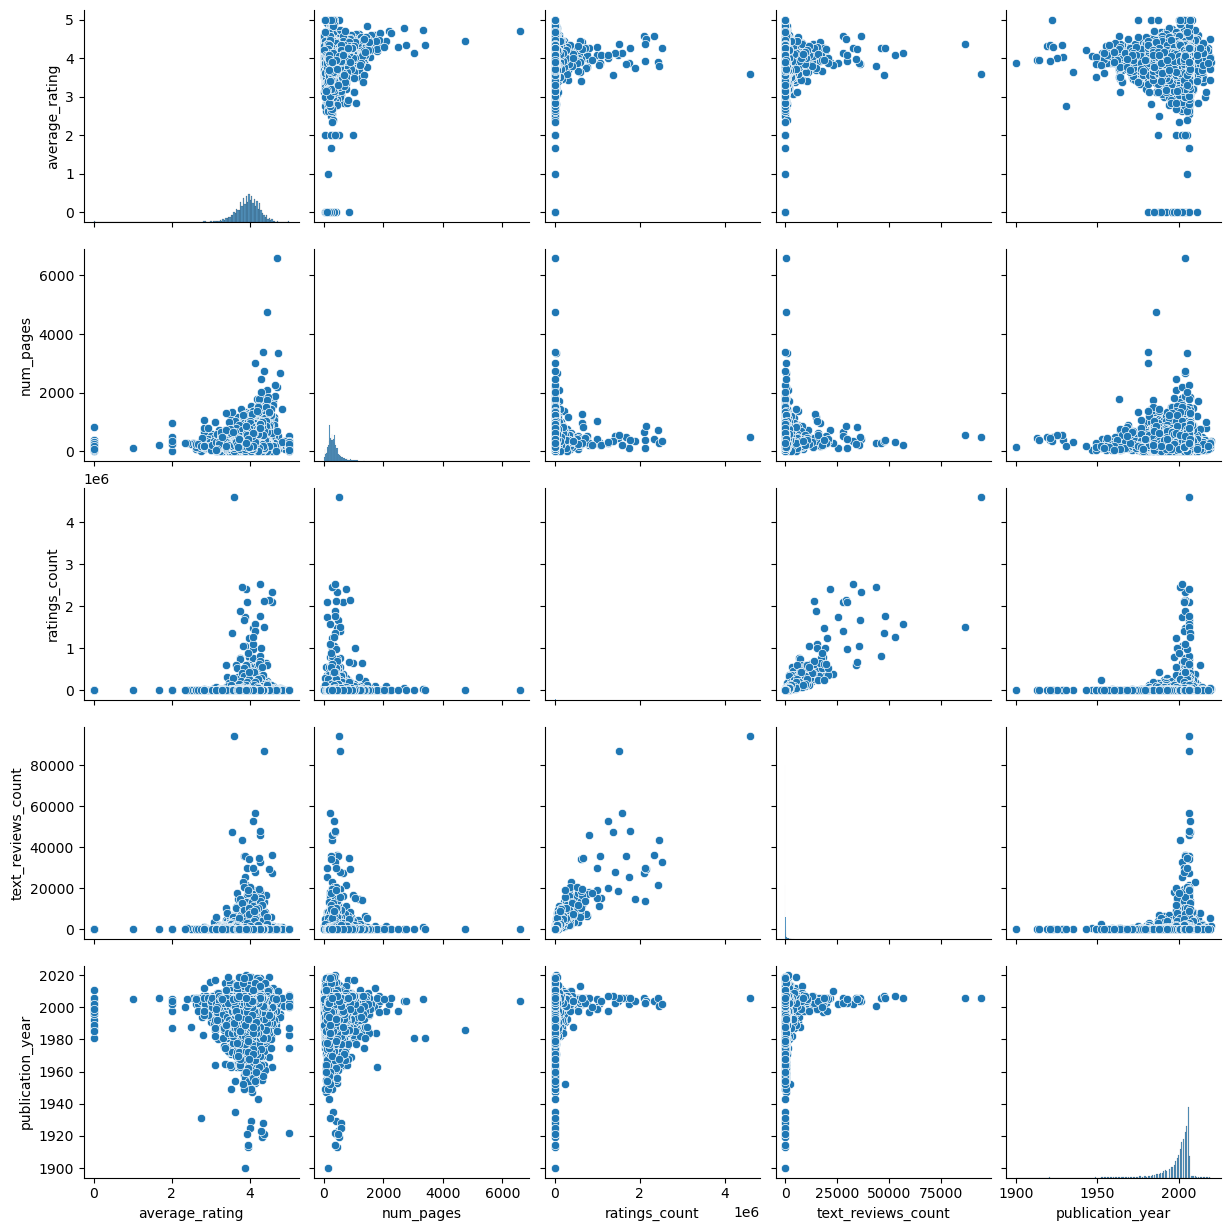

In [83]:
sns.pairplot(numerical_cols)

C:\Users\uwicl\AppData\Local\Temp\ipykernel_14012\1409653794.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  books_df[continuousVars].hist(ax = ax)


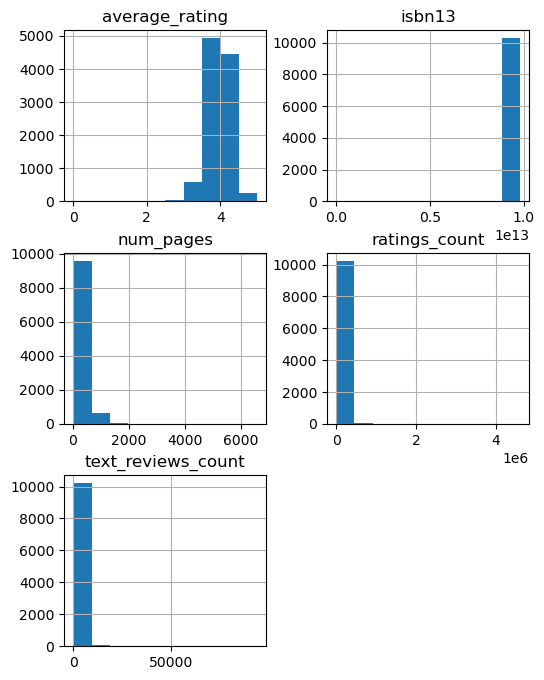

In [84]:
fig = plt.figure(figsize = (6,8))
ax = fig.gca()
books_df[continuousVars].hist(ax = ax)
plt.show()

* with right-skewed distributions, it shows that the mean is typically pulled toward the tail, while the majority of data points may be clustered on the lower end.

### 3.2 Analysis - Authors 

In [85]:
# Count the number of unique authors
books_df['clean_author'].nunique()

4153

In [86]:
books_df['author_Frequ'].nunique() # 

42

* There are 4,173 distinct authors, showcasing a rich diversity, with each author having at least one book."
* However, there are only 39 unique author frequency values, suggesting that many authors share the same number of published books.
* For example, some authors may have only published one book, others 2 books and so on...
* --> This implies a certain distribution pattern among the authors. Some authors might be prolific, appearing in the dataset many times, while others might have only appear once or two times . 
* Below a frequency table to give more visibilite in this regards.

In [87]:
# Step 1: Create a frequency distribution table
frequency_distribution = books_df['author_Frequ'].value_counts().sort_index()

# step 2: Convert frequency_distribution to DataFrame
freq_df = frequency_distribution.reset_index()
freq_df.columns = ['Number_of_books', 'Author_Frequencies']
freq_df = freq_df[['Author_Frequencies', 'Number_of_books']]
freq_df

# The results in the table below illustrate the following points:
# More than half of the authors have published only one book each.
# 992 authors have published two books each.
# 61 authors have published 61 books each.
# There are noticeable gaps in the number of author frequencies, indicating that no authors have published a number of books within certain ranges.
# For example, there's a jump from 45 to 61 books, meaning no authors have published between 46 and 60 books.

,Author_Frequencies,Number_of_books
0,2755,1
1,980,2
2,708,3
3,640,4
4,575,5
5,432,6
6,434,7
7,336,8
8,387,9
9,360,10


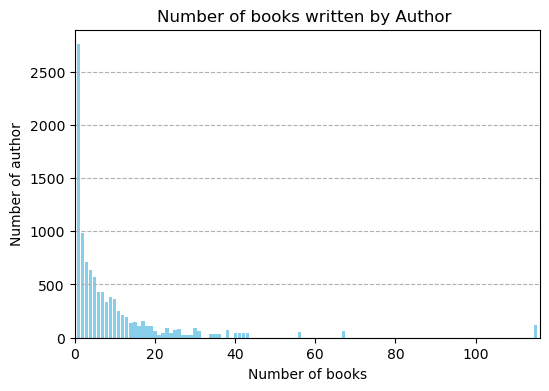

In [88]:
# Visualize the distribution of number of occurence of authors

plt.figure(figsize=(6,4))
plt.bar(freq_df['Number_of_books'], freq_df['Author_Frequencies'], color='skyblue')

# Labeling and titling
plt.xlabel('Number of books')
plt.ylabel('Number of author')
plt.title('Number of books written by Author ')

# Adding grid and rotating x-axis labels
plt.grid(axis='y', linestyle='--', alpha=1)
plt.xticks(rotation=0)

# Optionally set x-axis limits if needed
plt.xlim(min(freq_df['Number_of_books']) - 1, max(freq_df['Number_of_books']) + 1)

# Show the plot
plt.show()

we notice a significant variability in the data where the majority of the number of books are clustered on the lower end, showing that many authors have published a few number of books and a great number of them have only one book published.

### 3.3 Analyis - Average Rating

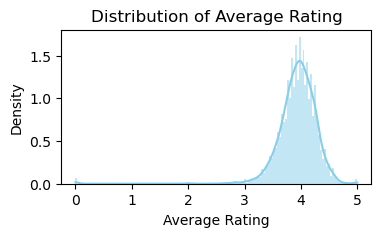

In [89]:
# let begin with  observing the distribution of average rating 

# Create a figure and axis for the plot
plt.figure(figsize=(4, 2))

# Plot histogram with KDE
sns.histplot(books_df['average_rating'], kde=True, stat='density', linewidth=0, color='skyblue')

# Add labels and title
plt.xlabel('Average Rating')
plt.ylabel('Density')
plt.title('Distribution of Average Rating')
plt.show()

* We can observe that the average rating is right skewed. 
* However , we also observe a kind of normal disribution between rating 3 and 5

Text(0.5, 1.0, 'average_rating_scale')

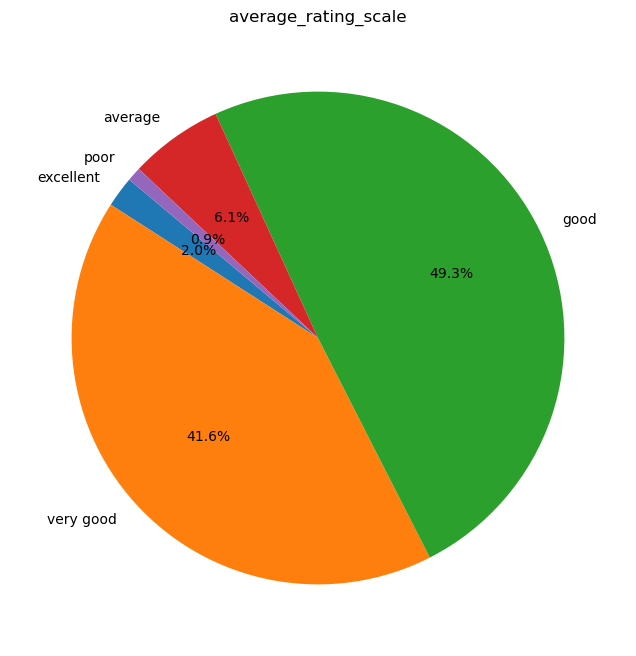

In [90]:
# Visualize the distribution of average Rating
desired_order = ['excellent','very good','good','average','poor']
# Sorting average rating scale
average_rating_scale = books_df['average_rating_scale'].value_counts()
average_rating_scale = average_rating_scale.reindex(desired_order, fill_value=0)

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(average_rating_scale, labels=average_rating_scale.index, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('average_rating_scale')

* 0 -3: poor , 3- 3.5: average, 3.5 -4 : good , 4-4.5: very good ,> 4.5 : excellent
* we observe that 90 % of the books are goot and very good rated 

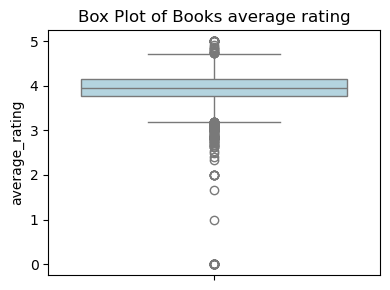

In [91]:
# Create a box plot with Seaborn
plt.figure(figsize=(4, 3))
sns.boxplot(y=books_df['average_rating'], color='lightblue')

# Labeling and titling
plt.title('Box Plot of Books average rating')

# Display the plot
plt.tight_layout()
plt.show()

### 3.4 Analyis - Language

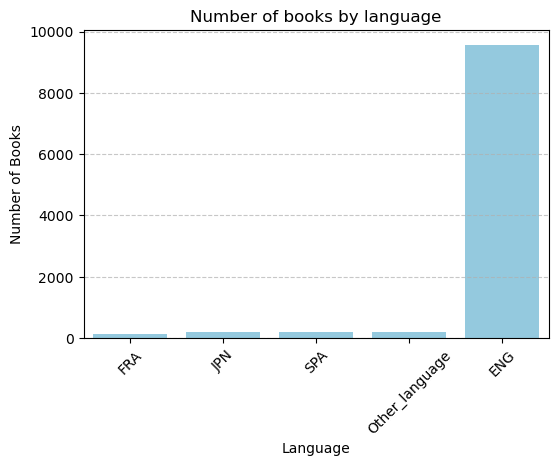

In [92]:
# Visualize the language
language_counts =books_df['language'].value_counts().sort_values()
# Plot the bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x=language_counts.index, y=language_counts.values, color='skyblue' )

# Labeling and titling
plt.xlabel('Language')
plt.ylabel('Number of Books')
plt.title('Number of books by language')

# Adding grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

* In 21 languages, more than 90 % (9732 books) of the books are written in english followed by spanish with 0.19 %.
* English language create an imbalance in our dataset 

### 3.5 Analyis - Number of pages 

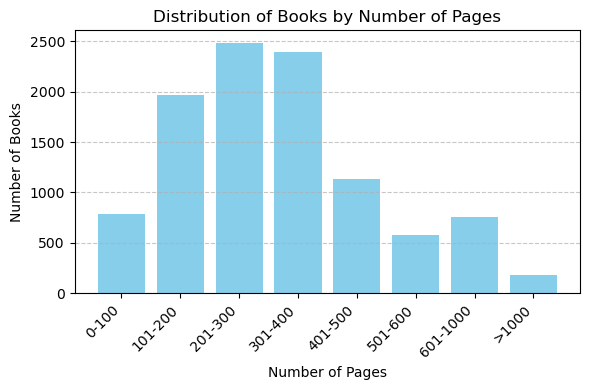

In [93]:
# Define the bins for the number of pages
bins = [0, 100, 200, 300, 400, 500, 600, 1000, float('inf')]  # Adjust the bins as needed
labels = ['0-100', '101-200', '201-300', '301-400', '401-500', '501-600', '601-1000', '>1000']

# Categorize the 'num_pages' into bins & Count the number of books in each bin
books_df['page_bins'] = pd.cut(books_df['num_pages'], bins=bins, labels=labels, right=True, include_lowest=True)
page_counts = books_df['page_bins'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(6, 4))
bars=plt.bar(page_counts.index, page_counts.values, color='skyblue')

# Labeling and titling
plt.xlabel('Number of Pages')
plt.ylabel('Number of Books')
plt.title('Distribution of Books by Number of Pages')

#  Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adding grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


* the page number varies between 200 and 400 for almost half of the books in the dataframe

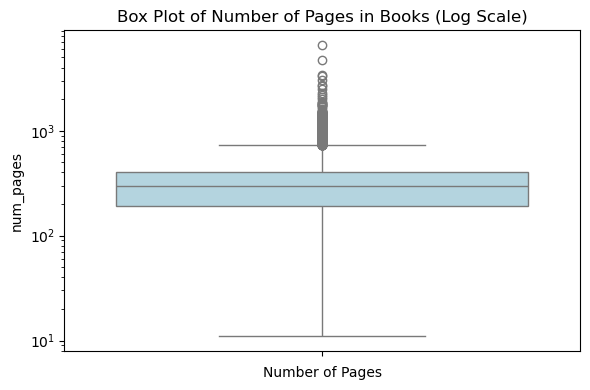

In [94]:
# Create a box plot with Seaborn
plt.figure(figsize=(6, 4))
sns.boxplot(y=books_df['num_pages'], color='lightblue')

# Set y-axis to a logarithmic scale
plt.yscale('log')

# Labeling and titling
plt.xlabel('Number of Pages')
plt.title('Box Plot of Number of Pages in Books (Log Scale)')

# Display the plot
plt.tight_layout()
plt.show()


### 3.5 Analyis - year of publication

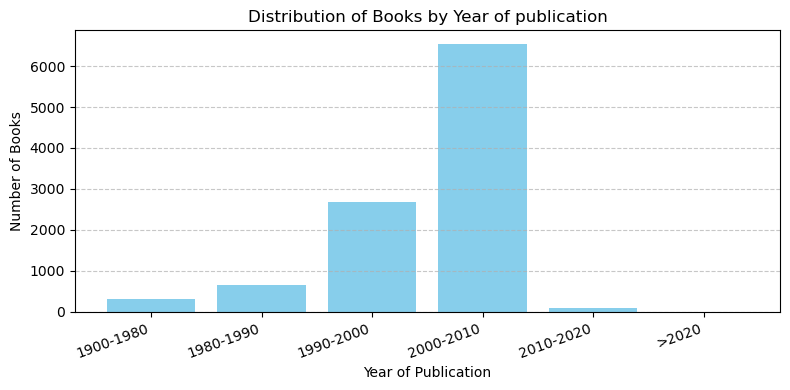

In [95]:
# Define year bins and labels
bins = [1900, 1980, 1990, 2000, 2010, 2020, float('inf')]
labels = ['1900-1980', '1980-1990', '1990-2000', '2000-2010', '2010-2020', '>2020']

# Categorize the 'num_pages' into bins & Count the number of books in each bin
books_df['year_bins'] = pd.cut(books_df['publication_year'], bins=bins, labels=labels, right=True, include_lowest=True)
publication_year_counts = books_df['year_bins'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(8, 4))
bars=plt.bar(publication_year_counts.index, publication_year_counts.values, color='skyblue')

# Labeling and titling
plt.xlabel('Year of Publication')
plt.ylabel('Number of Books')
plt.title('Distribution of Books by Year of publication')

#  Rotate the x-axis labels for better readability
plt.xticks(rotation=20, ha='right')

# Step 7: Adding grid lines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Step 8: Display the plot
plt.tight_layout()
plt.show()


* More than 50 % of the book has been published between 2000 -2010. No recent book has been published in our dataset

In [96]:
books_df.head(3)

,clean_title,clean_author,average_rating,isbn,isbn13,language,num_pages,ratings_count,text_reviews_count,publication_year,clean_publisher,title_Frequ,author_Frequ,language_Frequ,publisher_Frequ,average_rating_scale,num_books_each_class,page_bins,year_bins
0,harry potter and the half blood prince harry p...,J K Rowling,4.57,0439785960,9.780440e+12,ENG,652.0,2095690,27591,2006,scholastic inc,1,19,9571,21,excellent,207,601-1000,2000-2010
1,harry potter and the order of the phoenix harr...,J K Rowling,4.49,0439358078,9.780440e+12,ENG,870.0,2153167,29221,2004,scholastic inc,1,19,9571,21,very good,4279,601-1000,2000-2010
2,harry potter and the chamber of secrets harry ...,J K Rowling,4.42,0439554896,9.780440e+12,ENG,352.0,6333,244,2003,scholastic,1,19,9571,31,very good,4279,301-400,2000-2010


### 3.7 Analysis - authors & average rating 

Text(0, 0.5, 'Author Frequency')

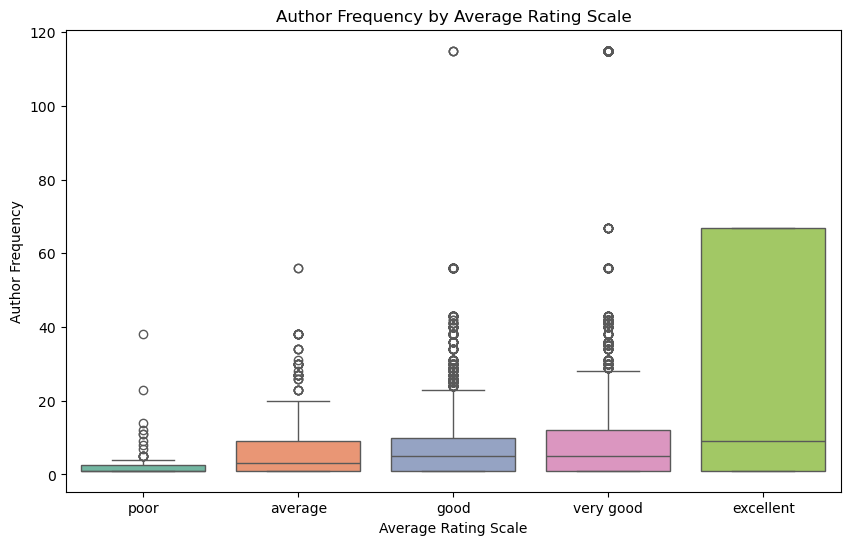

In [97]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=books_df, x='average_rating_scale', y='author_Frequ', hue='average_rating_scale', palette='Set2')

# Add titles and labels
plt.title('Author Frequency by Average Rating Scale')
plt.xlabel('Average Rating Scale')
plt.ylabel('Author Frequency')

* there relationship between the authors the averating can be clearly read from the above boxes but we can at least deduce that averating rating tends to increase with the accurence of the authors . this is even very visible with the book with excellent rating 

<Axes: xlabel='average_rating', ylabel='author_Frequ'>

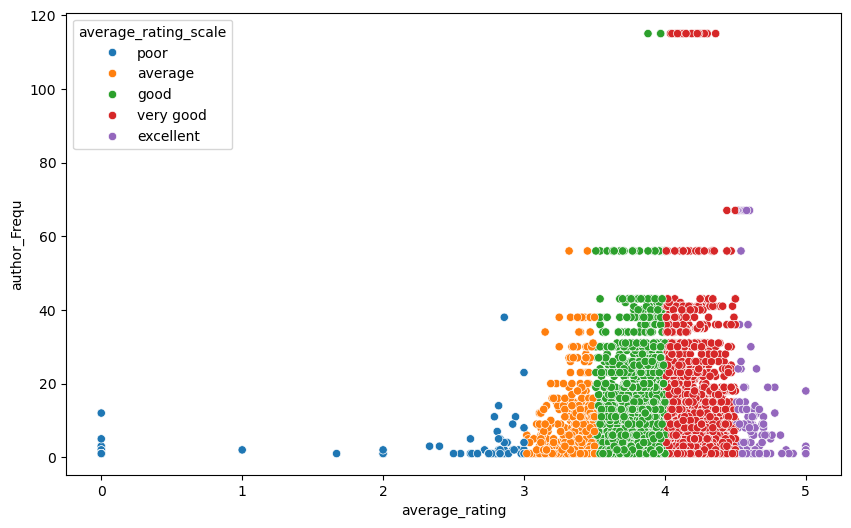

In [98]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=books_df, y='author_Frequ', x='average_rating',  hue='average_rating_scale' )

* using the number of accurance of authors, we can see that there is no relationship between these 2 variables, because there are many authors with  1 book well rated.

### 3.8 Analysis - Language & average rating

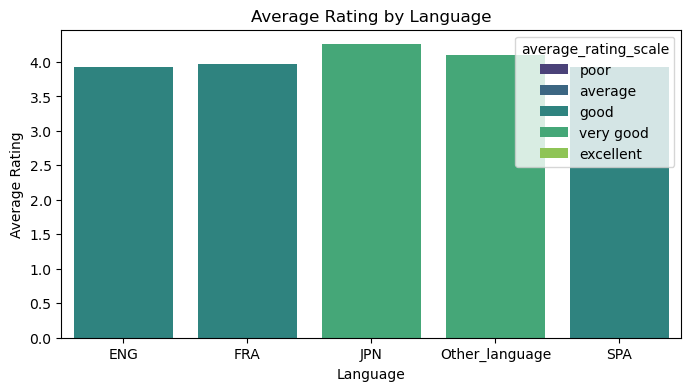

In [99]:
# Calculate the average rating for each language
# Assuming 'average_rating' is the column you want to average
average_ratings_by_language = books_df.groupby('language')['average_rating'].mean().reset_index()

# Add a column for the average rating scale
# If you don't already have this, you may need to create it
# For example:
average_ratings_by_language['average_rating_scale'] = pd.cut(
    average_ratings_by_language['average_rating'], 
    bins=[0, 3 , 3.5, 4, 4.5, float('inf')], 
    labels=['poor', 'average', 'good','very good', 'excellent'])

# Plotting the bar plot with Seaborn
plt.figure(figsize=(8, 4))
sns.barplot(
    data=average_ratings_by_language,
    x='language',
    y='average_rating',
    hue='average_rating_scale',
    palette='viridis')

# Labeling and titling
plt.xlabel('Language')
plt.ylabel('Average Rating')
plt.title('Average Rating by Language')

# Rotating x-axis labels for better readability
plt.xticks(rotation=0)

# Show the plot
plt.show()

<Axes: xlabel='language', ylabel='average_rating'>

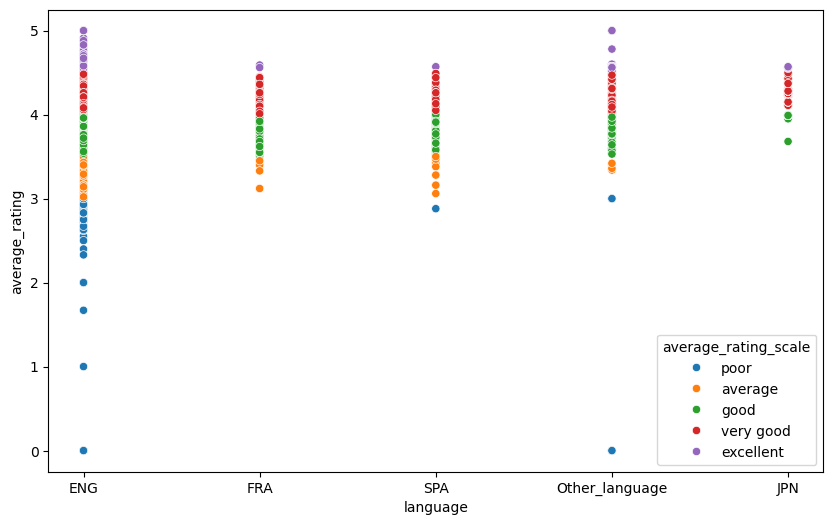

In [100]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=books_df, y='average_rating', x='language', hue='average_rating_scale' )

* There is no relationship between language and average rating

### 3.9 Analysis - number_pages & average rating

C:\Users\uwicl\AppData\Local\Temp\ipykernel_14012\2138740007.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(


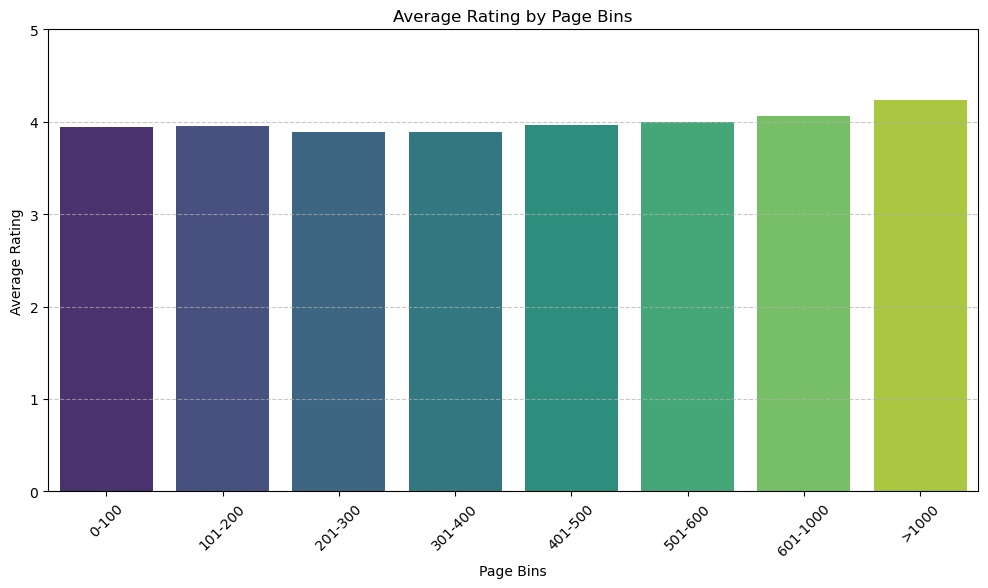

In [101]:
# Aggregate the data by 'page_bins' and calculate the mean of 'average_rating'
aggregated_df = books_df.groupby('page_bins', as_index=False, observed=False).agg({'average_rating': 'mean'})

# Set the figure size
plt.figure(figsize=(12, 6))

# Create the bar plot
bar_plot = sns.barplot(
    data=aggregated_df,
    x='page_bins',  # x-axis
    y='average_rating',  # y-axis
    palette='viridis',  # Color palette
    hue=None)

# Add labels and title
bar_plot.set_title('Average Rating by Page Bins')
bar_plot.set_xlabel('Page Bins')
bar_plot.set_ylabel('Average Rating')
plt.ylim(0, 5) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.xticks(rotation=45) 
plt.show()

<Axes: xlabel='num_pages', ylabel='average_rating'>

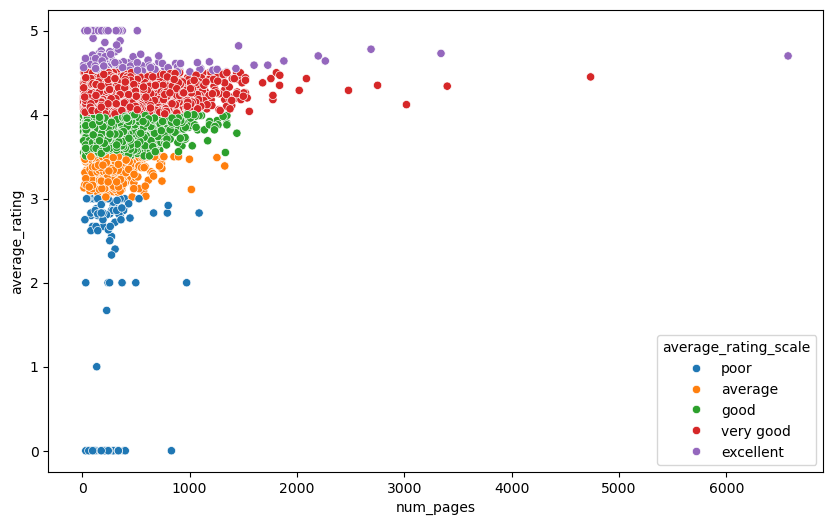

In [102]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=books_df, y='average_rating', x='num_pages',  hue='average_rating_scale' )

* It is hard to tell te relationship between the average rating and number of pages of books. 

### 3.10 Analysis - Ratings_count & average rating

<Axes: xlabel='ratings_count', ylabel='average_rating'>

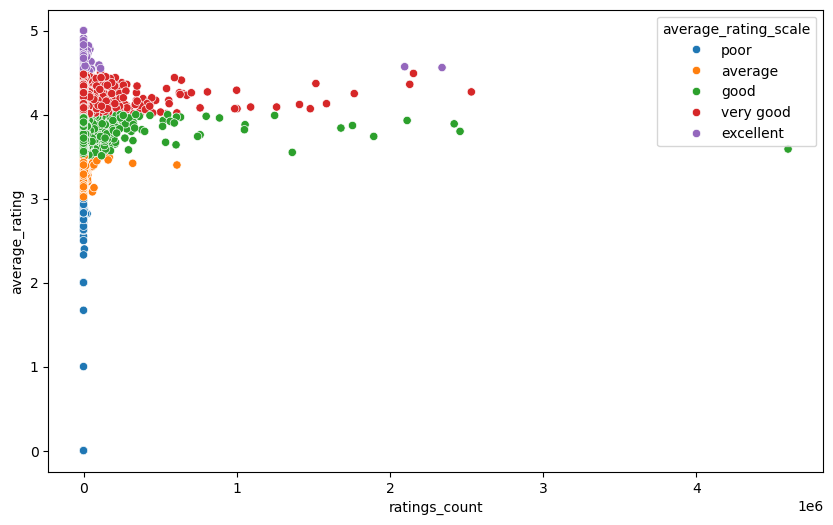

In [103]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=books_df, y='average_rating', x='ratings_count', hue='average_rating_scale' )

Text(0, 0.5, 'ratings_count')

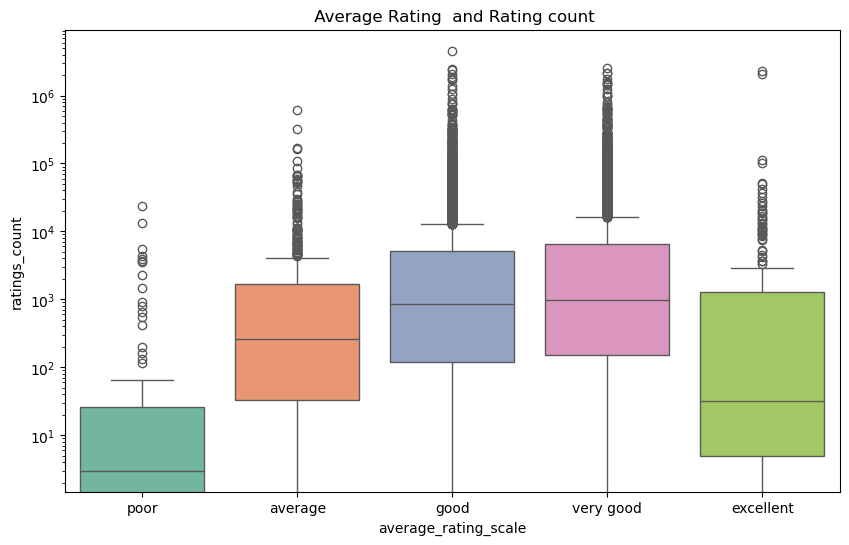

In [104]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=books_df, x='average_rating_scale', y='ratings_count', hue='average_rating_scale', palette='Set2')
# Set y-axis to a logarithmic scale
plt.yscale('log')

# Add titles and labels
plt.title(' Average Rating  and Rating count')
plt.xlabel('average_rating_scale')
plt.ylabel('ratings_count')

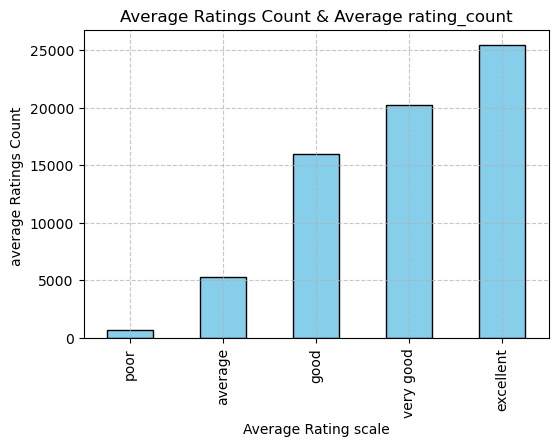

In [105]:
# Calculate the Mean of ratings_count by average_rating_scale group
ratings_count_mean = books_df.groupby('average_rating_scale',observed=False)['ratings_count'].mean()

# create a bar plot
plt.figure(figsize=(6, 4))
ratings_count_mean.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Average Rating scale')
plt.ylabel('average Ratings Count ')
plt.title('Average Ratings Count & Average rating_count')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### 3.11 Analysis - Text_reviews_count & average rating

Text(0, 0.5, 'ratings_count')

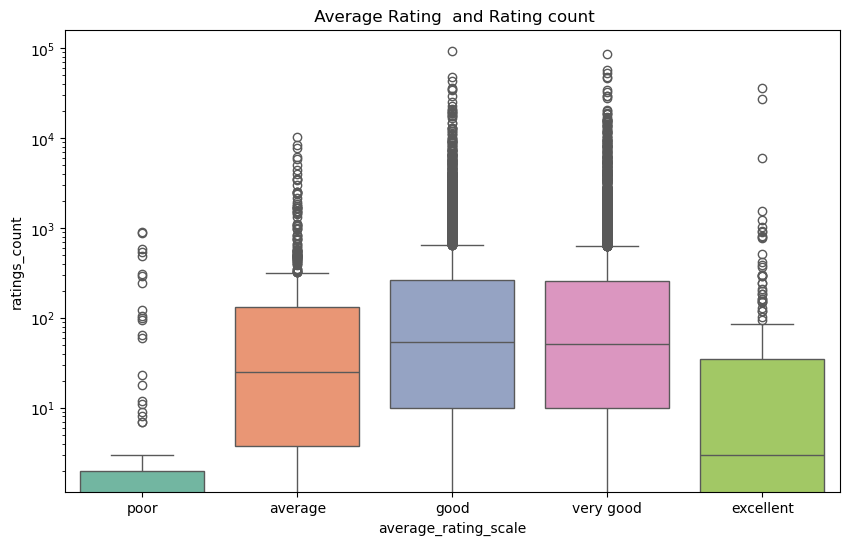

In [106]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=books_df, x='average_rating_scale', y='text_reviews_count', hue='average_rating_scale', palette='Set2')
# Set y-axis to a logarithmic scale
plt.yscale('log')

# Add titles and labels
plt.title(' Average Rating  and Rating count')
plt.xlabel('average_rating_scale')
plt.ylabel('ratings_count')

we can observe a raltionship between the average rating count mean and  average rating 

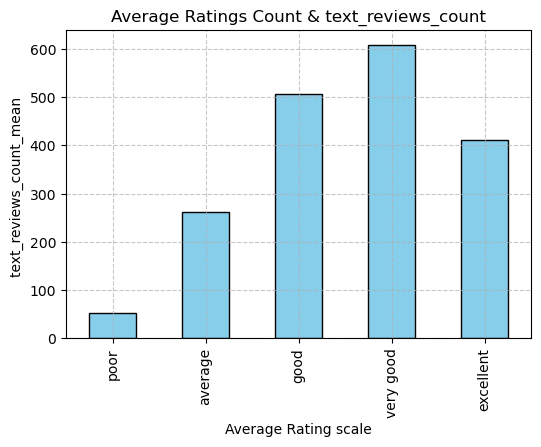

In [107]:
# Calculate the Mean of ratings_count by average_rating_scale group
text_reviews_count_mean = books_df.groupby('average_rating_scale',observed=False)['text_reviews_count'].mean()

# create a bar plot
plt.figure(figsize=(6, 4))
text_reviews_count_mean.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Average Rating scale')
plt.ylabel('text_reviews_count_mean ')
plt.title('Average Ratings Count & text_reviews_count')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

* Between the relationship  text_reviews count and average rating can not be determined. although we see relationship at certain
* point, but when we arrive excellent , we loose the relationship

### 3.12 Rating_count & text_review count

<Axes: xlabel='text_reviews_count', ylabel='ratings_count'>

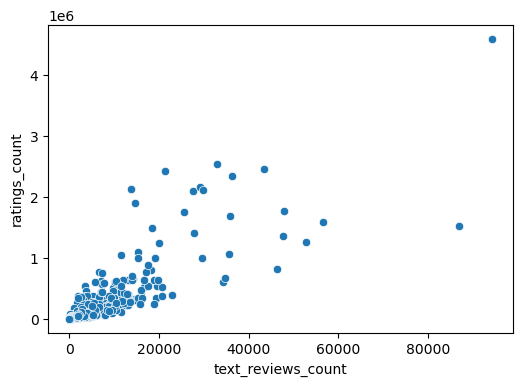

In [108]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=books_df, y='ratings_count', x='text_reviews_count' )

In [109]:
# we can see a relationship between rating count and text_reviews count 

### 3.13 Average rating & publication year

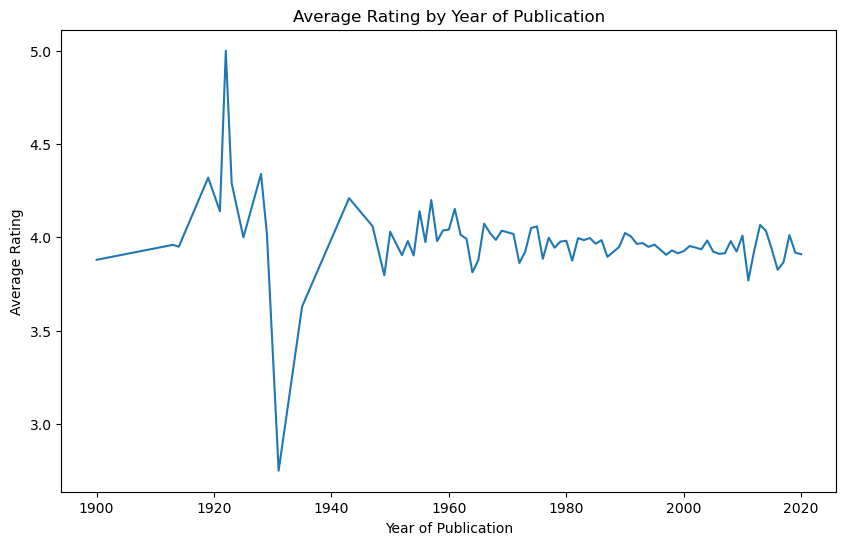

In [110]:
# Group the data by year and calculate the mean average rating per year
avg_rating_per_year = books_df.groupby('publication_year')['average_rating'].mean().reset_index()

# Plotting the line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=avg_rating_per_year, x='publication_year', y='average_rating')

# Adding labels and title
plt.xlabel('Year of Publication')
plt.ylabel('Average Rating')
plt.title('Average Rating by Year of Publication')

# Show the plot
plt.show()


* We can see there is no much change in average rating between 1950 and 2020.
* There is no correlation between publication year and average rating
* but we can observe that the book rating has been decreasing till 2000 when it raised up 2010. note also in that period, a * * * large number of book were published
* And from 2010 to 2020 there was a rise of average rating which again decreased from 2020

### 3.14 Best or bad books 

In [111]:
Rating=['num_pages','ratings_count','text_reviews_count','average_rating']

<Axes: xlabel='average_rating', ylabel='clean_title'>

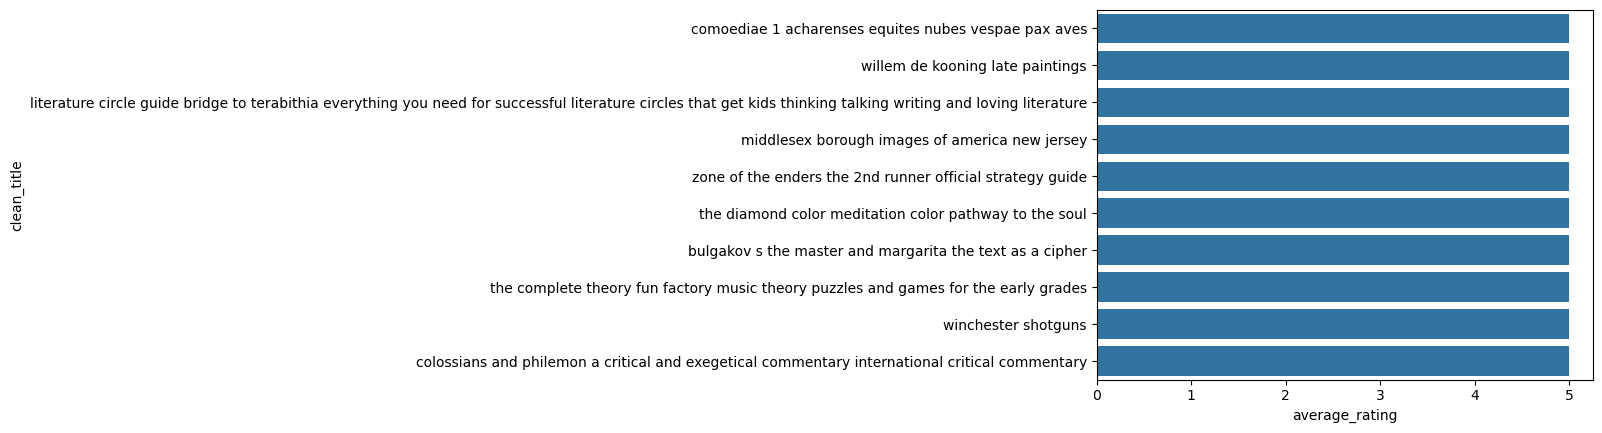

In [112]:
# top ten books with the best highest average rating
title_top_rating = books_df.nlargest(10, ['average_rating']).set_index('clean_title')['average_rating']
sns.barplot(x=title_top_rating, y=title_top_rating.index)

In [113]:
goodbooks=books_df[books_df['average_rating']>=3.5]
badbooks=books_df[books_df['average_rating']<3.5]

In [114]:
best_authors = goodbooks.groupby('clean_author')['clean_author'].count().sort_values(ascending=False).head(10)
worst_authors = badbooks.groupby('clean_author')['clean_author'].count().sort_values(ascending=True).head(10)

#best_publishers = goodbooks.groupby('publisher')['publisher'].count().sort_values(ascending=False).head(10)
# worst_publishers = badbooks.groupby('publisher')['publisher'].count().sort_values(ascending=True).head(10)

best_pulicaion_year = goodbooks.groupby('publication_year')['publication_year'].count().sort_values(ascending=False).head(10)
worst_pulicaion_year = badbooks.groupby('publication_year')['publication_year'].count().sort_values(ascending=True).head(10)

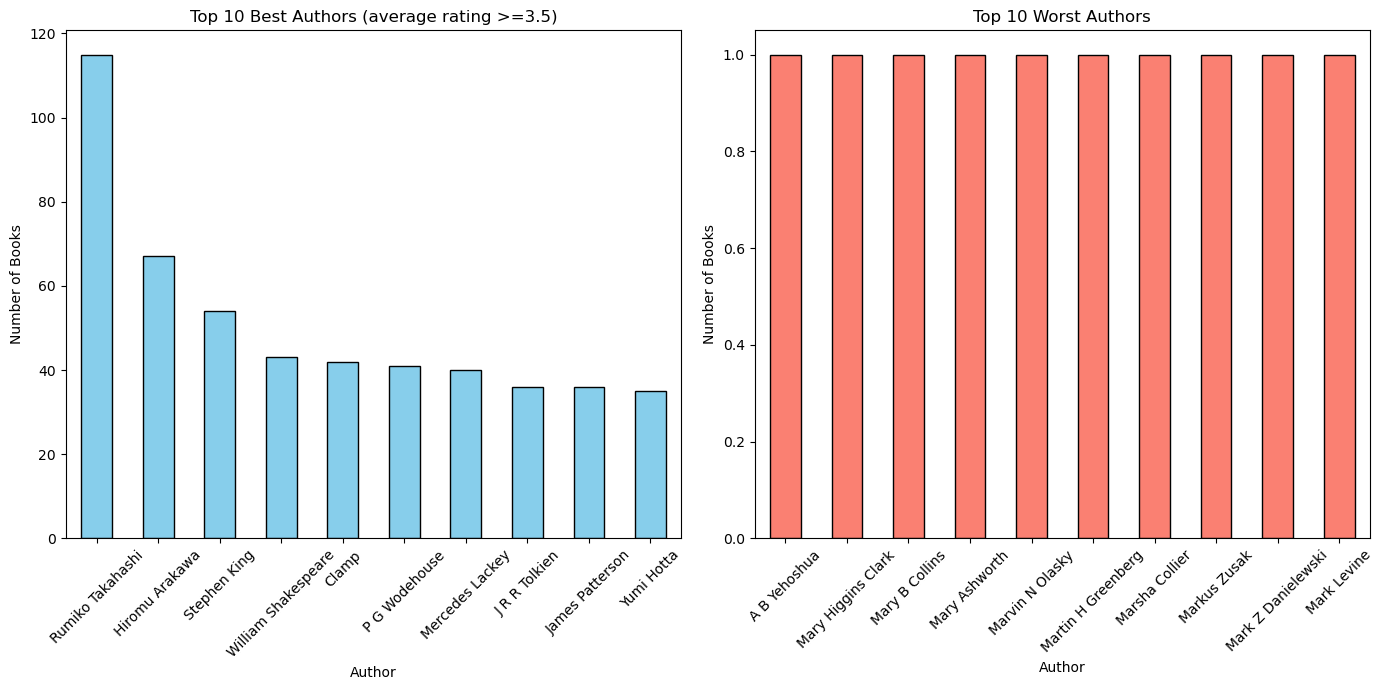

In [115]:
# Create figure and axes for the bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot top 10 best authors
best_authors.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black',)
axes[0].set_title('Top 10 Best Authors (average rating >=3.5)')
axes[0].set_xlabel('Author')
axes[0].set_ylabel('Number of Books')
axes[0].tick_params(axis='x', rotation=45)

# Plot top 10 worst authors
worst_authors.plot(kind='bar', ax=axes[1], color='salmon', edgecolor='black')
axes[1].set_title('Top 10 Worst Authors')
axes[1].set_xlabel('Author')
axes[1].set_ylabel('Number of Books')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

* 10 best authors have published between 40 and 61 books while the 10 tails authors have each published one book.

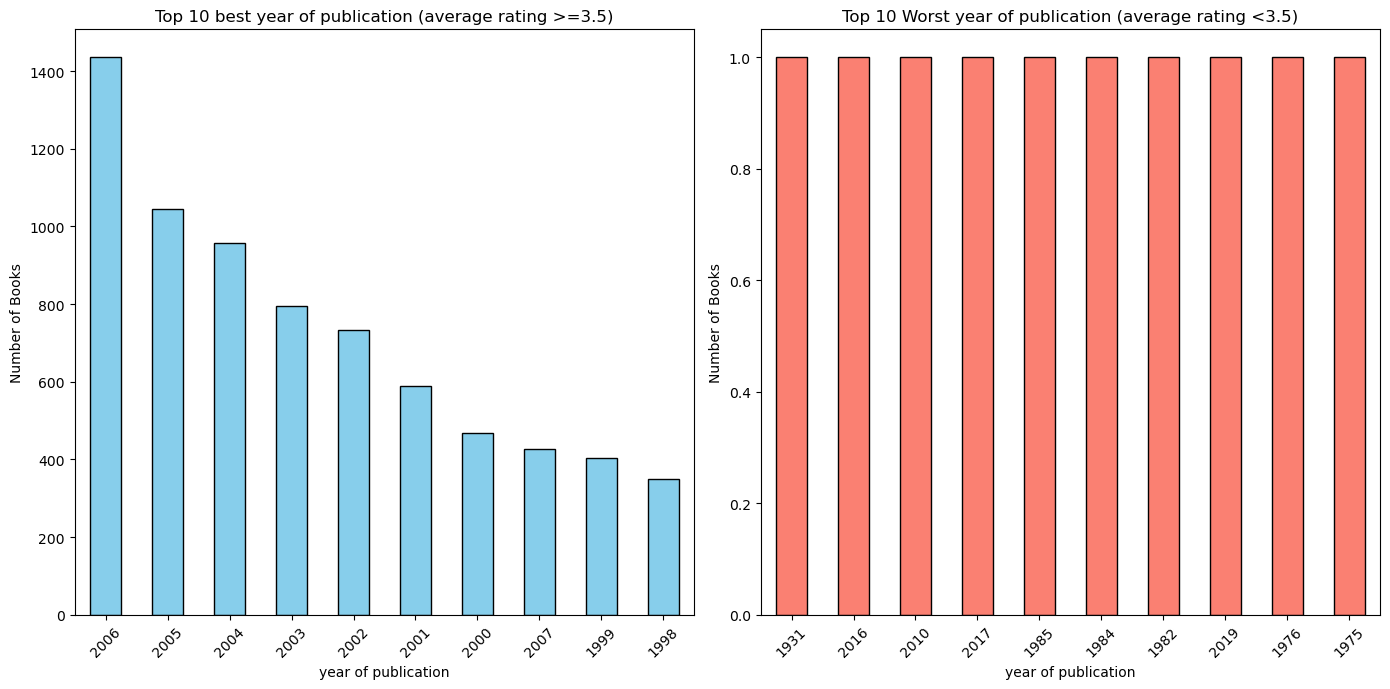

In [116]:
# Create figure and axes for the bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot top 10 best year of publication
best_pulicaion_year.plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Top 10 best year of publication (average rating >=3.5)')
axes[0].set_xlabel('year of publication')
axes[0].set_ylabel('Number of Books')
axes[0].tick_params(axis='x', rotation=45)

# Plot top 10 worst publishers
worst_pulicaion_year.plot(kind='bar', ax=axes[1], color='salmon', edgecolor='black')
axes[1].set_title('Top 10 Worst year of publication (average rating <3.5)')
axes[1].set_xlabel('year of publication')
axes[1].set_ylabel('Number of Books')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

In [117]:
 books_df.head(1)

,clean_title,clean_author,average_rating,isbn,isbn13,language,num_pages,ratings_count,text_reviews_count,publication_year,clean_publisher,title_Frequ,author_Frequ,language_Frequ,publisher_Frequ,average_rating_scale,num_books_each_class,page_bins,year_bins
0,harry potter and the half blood prince harry p...,J K Rowling,4.57,0439785960,9.780440e+12,ENG,652.0,2095690,27591,2006,scholastic inc,1,19,9571,21,excellent,207,601-1000,2000-2010


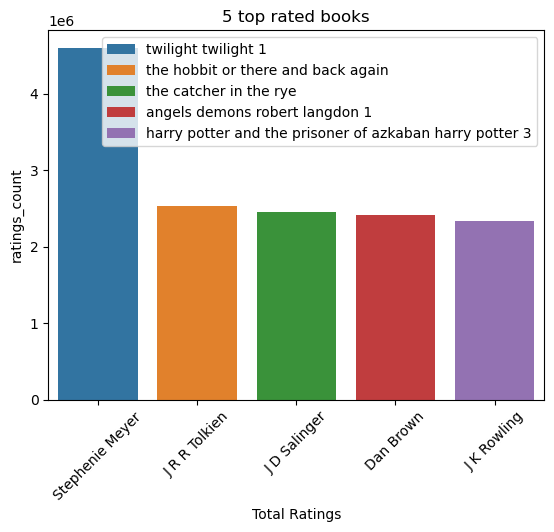

In [118]:
# authors with highest rated books
authors = books_df.nlargest(5, ['ratings_count']).set_index('clean_author')
sns.barplot(y=authors['ratings_count'], x=authors.index, hue = authors['clean_title'])
plt.xlabel('Total Ratings')
plt.title('5 top rated books')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

### 3.15 Deep look into outliers

* Next time I will analize the avera rating in comparison to every variable

In [119]:
# from the data cleaning phase 
# Create a sub-dataframe with outliers
outliers_df = books_df.loc[outliers_indices]

In [120]:
outliers_df.shape

(544, 19)

Text(0.5, 1.0, 'average_rating_scale-outliers')

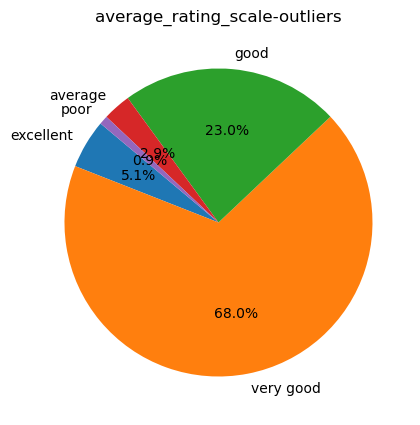

In [121]:
# Visualize the distribution of average Rating
desired_order = ['excellent','very good','good','average','poor']
# Sorting average rating scale
average_rating_scale_outliers = outliers_df['average_rating_scale'].value_counts()
average_rating_scale_outliers = average_rating_scale_outliers.reindex(desired_order, fill_value=0)

# Plotting the pie chart
plt.figure(figsize=(5, 5))
plt.pie(average_rating_scale_outliers, labels=average_rating_scale_outliers.index, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('average_rating_scale-outliers')

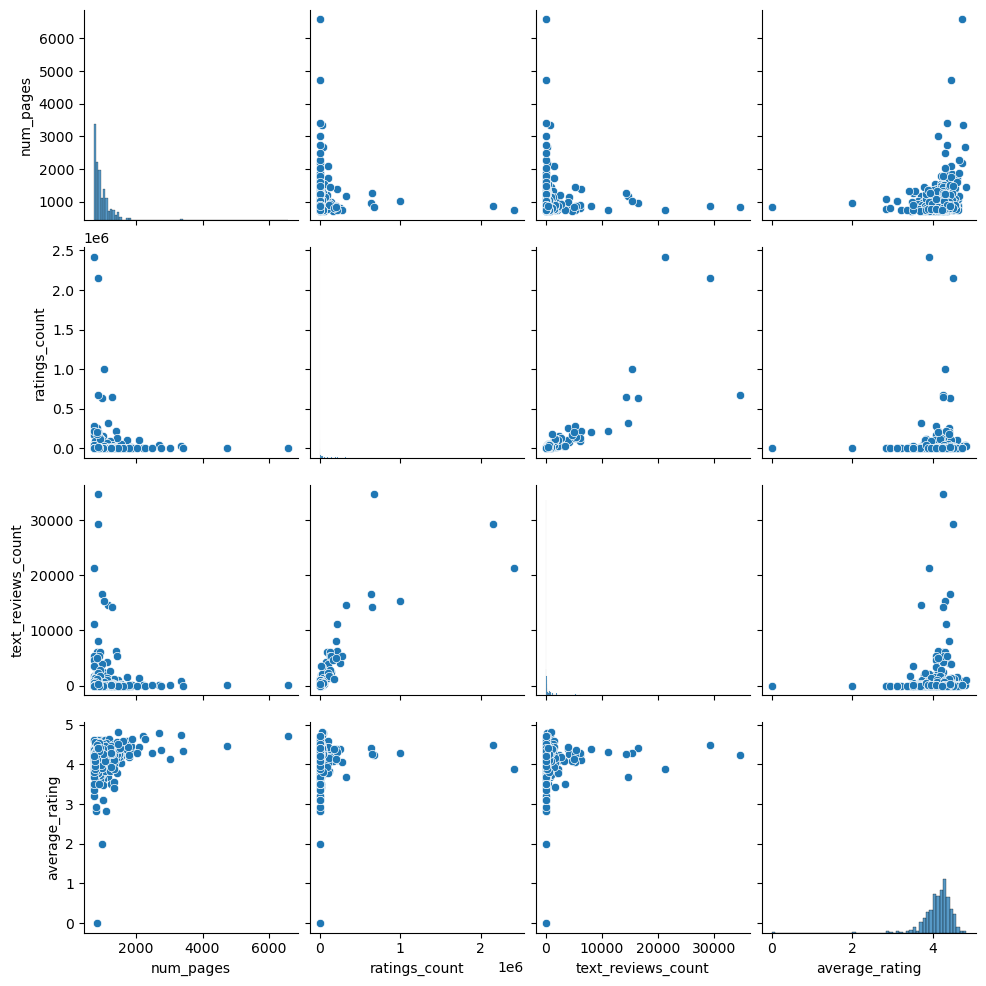

In [122]:
sns.pairplot(outliers_df[Rating])

* we can see that outliers behave in the same way as the whole dataset

# 4. FEATURES ENGINEERING AND FEATURES SELECTION
 

In [123]:
# Creating a copy of data Frame to be used for processing 
books_processed=books_df.copy()

In [124]:
books_processed.shape

(10287, 19)

In [125]:
books_processed.columns

Index(['clean_title', 'clean_author', 'average_rating', 'isbn', 'isbn13',
       'language', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_year', 'clean_publisher', 'title_Frequ', 'author_Frequ',
       'language_Frequ', 'publisher_Frequ', 'average_rating_scale',
       'num_books_each_class', 'page_bins', 'year_bins'],
      dtype='object')

In [126]:
# Dropping some columns
List_drop=['clean_author','isbn', 'isbn13','clean_publisher','title_Frequ','language_Frequ','num_books_each_class',
           'page_bins', 'year_bins']
books_processed.drop(List_drop, axis=1, inplace=True)

In [127]:
# Check the number of NaN values per column
books_processed.isnull().any()

clean_title             False
average_rating          False
language                False
num_pages               False
ratings_count           False
text_reviews_count      False
publication_year        False
author_Frequ            False
publisher_Frequ         False
average_rating_scale    False
dtype: bool

In [128]:
#  uncoding  average class
books_processed.rename(columns={'average_rating_scale': 'average_rating_class'}, inplace=True)

books_processed['average_rating_class'] = pd.factorize(books_processed['average_rating_class'])[0]

In [129]:
# uncoding language column
# Step1: Create dummy variables for the 'language' column
dummies = pd.get_dummies(books_processed['language'], prefix='Lang')

In [130]:
# Concatenate the original DataFrame with the dummies DataFrame 
books_processed = pd.concat([books_processed, dummies], axis=1).drop(columns="language")

In [131]:
#
boolean_columns = books_processed.select_dtypes(include='bool').columns
books_processed[boolean_columns] = books_processed[boolean_columns].astype(int)

In [132]:
from sklearn.preprocessing import MinMaxScaler

# Define the list of numerical columns
numerical_cols_list = ['num_pages', 'ratings_count', 'text_reviews_count', 'publication_year']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the numerical columns (this computes the min and max)
scaler.fit(books_processed[numerical_cols_list])

# Apply the scaling (this transforms the data using the fitted min and max values)
books_processed[numerical_cols_list] = scaler.transform(books_processed[numerical_cols_list])

In [133]:
# Create a new feature ' text_reviews_count_to_rating_count_ratio'
books_processed['textreview_to_ratingcount_ratio'] = books_processed['text_reviews_count'] / books_processed['ratings_count']

# Replace infinite values with NaN
books_processed['textreview_to_ratingcount_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill any NaN or infinite values resulting from division by zero
books_processed['textreview_to_ratingcount_ratio'].fillna(0, inplace=True)

C:\Users\uwicl\AppData\Local\Temp\ipykernel_14012\2428338395.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books_processed['textreview_to_ratingcount_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\uwicl\AppData\Local\Temp\ipykernel_14012\2428338395.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

In [134]:
# Check the number of NaN values per column
books_processed.isnull().sum()

clean_title                        0
average_rating                     0
num_pages                          0
ratings_count                      0
text_reviews_count                 0
publication_year                   0
author_Frequ                       0
publisher_Frequ                    0
average_rating_class               0
Lang_ENG                           0
Lang_FRA                           0
Lang_JPN                           0
Lang_Other_language                0
Lang_SPA                           0
textreview_to_ratingcount_ratio    0
dtype: int64

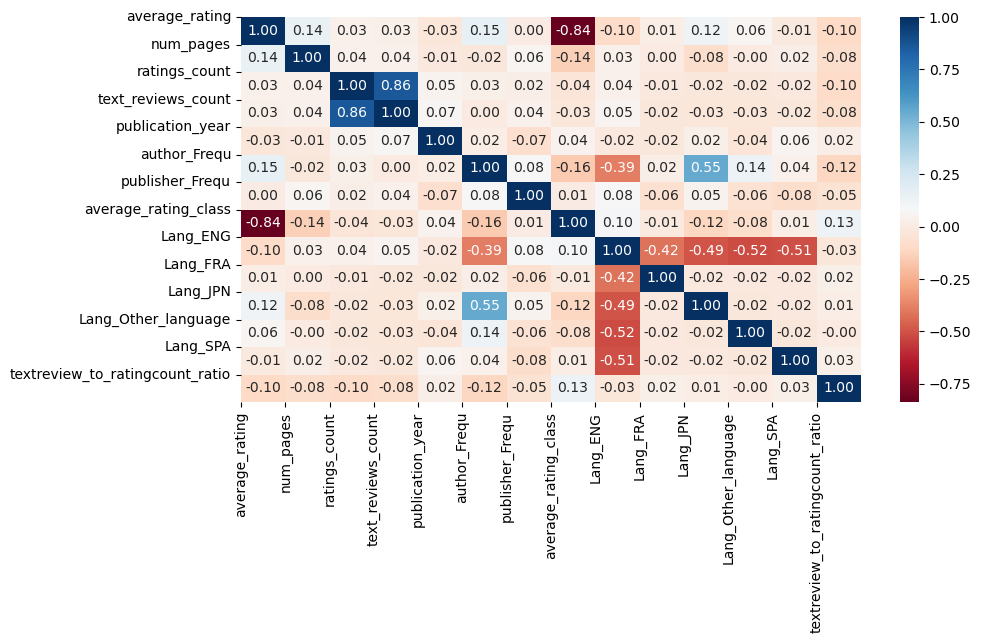

In [135]:
# Select only numerical variables
numerical_columns = books_processed.select_dtypes(include=['number']).columns
books_numerical = books_processed[numerical_columns]

# Create a corralation matrix
Correlation_Matr =books_numerical.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(Correlation_Matr, cmap='RdBu', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(Correlation_Matr.columns)), Correlation_Matr.columns);
#Apply yticks
plt.yticks(range(len(Correlation_Matr.columns)), Correlation_Matr.columns)
#show plot
plt.show()

In [136]:
# lowering case for 'authors' column 
# books_processed['clean_author'] = books_processed['clean_author'].str.lower()

In [137]:
# convert 'authors' column to numeric --> this bring out the author popularity depending on how many he/she appears
# books_processed['clean_author'] = pd.factorize(books_processed['clean_author'])[0]

In [138]:
# lowering case for 'authors' column 
# books_processed['clean_publisher'] = books_processed['clean_publisher'].str.lower()

In [139]:
# convert 'authors' column to numeric --> this bring out the author popularity depending on how many he/she appears
# books_processed['clean_publisher'] = pd.factorize(books_processed['clean_publisher'])[0]

### Text Encoding : Title, Authors & Publisher

In [140]:
# lowering case for 'title' column 
books_processed['clean_title'] = books_processed['clean_title'].str.lower()

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer 
title = TfidfVectorizer(max_features=50, stop_words='english',ngram_range = (3,3))

# min_df:minimumfractionofdocumentsthewordmustoccur
# max_df:maximumfractionofdocumentsthewordcanoccur

# Fit the vectroizer and transform the data
title_transformed = title.fit_transform(books_processed['clean_title'])
# Fit the vectroizer and transform the data

# Create a DataFrame with the title words
title_transformed_df = pd.DataFrame(title_transformed.toarray(),columns=title.get_feature_names_out()).add_prefix('T_TFIDF_')

title_transformed_df.index = books_processed.index

In [142]:
examine_row = title_transformed_df.iloc[2]
print(examine_row.sort_values(ascending=False).head(5))

T_TFIDF_11 kimi wa               0.0
T_TFIDF_star wars new            0.0
T_TFIDF_maison ikkoku volume     0.0
T_TFIDF_mrs piggle wiggle        0.0
T_TFIDF_murder hannah swensen    0.0
Name: 2, dtype: float64


In [143]:
title_transformed_df_sums = title_transformed_df.sum()
title_transformed_df_sums.sort_values(ascending=False).head()

T_TFIDF_sweet valley high         15.000000
T_TFIDF_laura ingalls wilder      14.527378
T_TFIDF_jojo bizarre adventure    14.002018
T_TFIDF_anita blake vampire       12.727922
T_TFIDF_blake vampire hunter      12.727922
dtype: float64

In [144]:
# Add the new columns to the original DataFrame
books_processed= pd.concat([books_processed, title_transformed_df],axis=1, sort=False)

In [145]:
books_processed_1=books_processed.copy()

In [146]:
# Droping Ttile and average_rating_class column
books_processed.drop(['clean_title','average_rating_class'], axis=1,inplace=True)

In [147]:
books_processed.head(3)

,average_rating,num_pages,ratings_count,text_reviews_count,publication_year,author_Frequ,publisher_Frequ,Lang_ENG,Lang_FRA,Lang_JPN,...,T_TFIDF_tsubasa reservoir chronicle,T_TFIDF_virginia woolf volume,T_TFIDF_vol fullmetal alchemist,T_TFIDF_vs toya koyo,T_TFIDF_wa petto 11,T_TFIDF_wars light shadow,T_TFIDF_women laura ingalls,T_TFIDF_world war ii,T_TFIDF_writings young women,T_TFIDF_yakitate japan volume
0,4.57,0.097639,0.455816,0.292696,0.883333,19,21,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.49,0.130845,0.468317,0.309988,0.866667,19,21,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.42,0.051942,0.001377,0.002588,0.858333,19,31,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [148]:
books_df.isnull().values.any()

False

In [149]:
print(books_processed.shape)
# checking the data types and see if they are discrete or continuaous only
books_processed.dtypes

(10287, 63)


average_rating                   float64
num_pages                        float64
ratings_count                    float64
text_reviews_count               float64
publication_year                 float64
                                  ...   
T_TFIDF_wars light shadow        float64
T_TFIDF_women laura ingalls      float64
T_TFIDF_world war ii             float64
T_TFIDF_writings young women     float64
T_TFIDF_yakitate japan volume    float64
Length: 63, dtype: object

In [150]:
books_processed.shape

(10287, 63)

# 5. MACHINE LEARNING

## A. Training the model as Regression

# Dataset Splitting 

In [151]:
books_processed_R=books_processed.copy()

In [152]:
books_processed_R.head(3)

,average_rating,num_pages,ratings_count,text_reviews_count,publication_year,author_Frequ,publisher_Frequ,Lang_ENG,Lang_FRA,Lang_JPN,...,T_TFIDF_tsubasa reservoir chronicle,T_TFIDF_virginia woolf volume,T_TFIDF_vol fullmetal alchemist,T_TFIDF_vs toya koyo,T_TFIDF_wa petto 11,T_TFIDF_wars light shadow,T_TFIDF_women laura ingalls,T_TFIDF_world war ii,T_TFIDF_writings young women,T_TFIDF_yakitate japan volume
0,4.57,0.097639,0.455816,0.292696,0.883333,19,21,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.49,0.130845,0.468317,0.309988,0.866667,19,21,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.42,0.051942,0.001377,0.002588,0.858333,19,31,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [153]:
from sklearn.model_selection import train_test_split

In [154]:
# the size of the test is 20% and the train is 80%
df_train, df_test = train_test_split(books_processed_R,test_size = 0.2,random_state=42)

In [155]:
# Total records for dataset
len(books_processed_R)

10287

In [156]:
# Total records for training the model
len(df_train)

8229

In [157]:
# Total records for testing the model
len(df_test)

2058

In [158]:
df_train

,average_rating,num_pages,ratings_count,text_reviews_count,publication_year,author_Frequ,publisher_Frequ,Lang_ENG,Lang_FRA,Lang_JPN,...,T_TFIDF_tsubasa reservoir chronicle,T_TFIDF_virginia woolf volume,T_TFIDF_vol fullmetal alchemist,T_TFIDF_vs toya koyo,T_TFIDF_wa petto 11,T_TFIDF_wars light shadow,T_TFIDF_women laura ingalls,T_TFIDF_world war ii,T_TFIDF_writings young women,T_TFIDF_yakitate japan volume
10119,3.88,0.072963,0.001720,0.003702,0.741667,11,4,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4092,3.28,0.040975,0.006093,0.016040,0.866667,14,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9702,4.03,0.042193,0.000006,0.000011,0.866667,1,9,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,3.73,0.022696,0.000633,0.002334,0.816667,11,36,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2860,4.11,0.086062,0.000267,0.000838,0.783333,4,296,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,3.88,0.074334,0.000035,0.000085,0.883333,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5261,4.40,0.027570,0.000094,0.000467,0.808333,1,11,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5490,3.83,0.005331,0.000371,0.001814,0.866667,24,18,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
866,4.16,0.026961,0.000002,0.000011,0.758333,6,5,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [159]:
books_processed_R.columns

Index(['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_year', 'author_Frequ', 'publisher_Frequ', 'Lang_ENG',
       'Lang_FRA', 'Lang_JPN', 'Lang_Other_language', 'Lang_SPA',
       'textreview_to_ratingcount_ratio', 'T_TFIDF_11 kimi wa',
       'T_TFIDF_14 sai vs', 'T_TFIDF_admiral arnold morgan',
       'T_TFIDF_adventures bailey school', 'T_TFIDF_alchemist vol fullmetal',
       'T_TFIDF_alice adventures wonderland', 'T_TFIDF_anita blake vampire',
       'T_TFIDF_bailey school kids', 'T_TFIDF_bizarre adventure tome',
       'T_TFIDF_blake vampire hunter', 'T_TFIDF_brave new world',
       'T_TFIDF_clancy net force', 'T_TFIDF_complete greek tragedies',
       'T_TFIDF_complete short stories', 'T_TFIDF_cr nicas rnia',
       'T_TFIDF_dance music time', 'T_TFIDF_death note vol',
       'T_TFIDF_diary ana nin', 'T_TFIDF_drifting classroom vol',
       'T_TFIDF_fullmetal alchemist vol', 'T_TFIDF_harry bosch universe',
       'T_TFIDF_history midd

In [160]:
# Transform the test data 
# df_test[numerical_cols_list] = scaler.transform(df_test[numerical_cols_list])

In [161]:
# Check the data is ramdomly selected
print(books_processed_R.average_rating.mean())
print(df_train.average_rating.mean())
print(df_test.average_rating.mean())

3.9399581996694857
3.941663628630453
3.9331389698736636


In [162]:
# Review the features and the target to be used for the machine learning
df_train.columns

Index(['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_year', 'author_Frequ', 'publisher_Frequ', 'Lang_ENG',
       'Lang_FRA', 'Lang_JPN', 'Lang_Other_language', 'Lang_SPA',
       'textreview_to_ratingcount_ratio', 'T_TFIDF_11 kimi wa',
       'T_TFIDF_14 sai vs', 'T_TFIDF_admiral arnold morgan',
       'T_TFIDF_adventures bailey school', 'T_TFIDF_alchemist vol fullmetal',
       'T_TFIDF_alice adventures wonderland', 'T_TFIDF_anita blake vampire',
       'T_TFIDF_bailey school kids', 'T_TFIDF_bizarre adventure tome',
       'T_TFIDF_blake vampire hunter', 'T_TFIDF_brave new world',
       'T_TFIDF_clancy net force', 'T_TFIDF_complete greek tragedies',
       'T_TFIDF_complete short stories', 'T_TFIDF_cr nicas rnia',
       'T_TFIDF_dance music time', 'T_TFIDF_death note vol',
       'T_TFIDF_diary ana nin', 'T_TFIDF_drifting classroom vol',
       'T_TFIDF_fullmetal alchemist vol', 'T_TFIDF_harry bosch universe',
       'T_TFIDF_history midd

In [163]:
X_train = df_train.drop(columns=['average_rating'])
y_train = df_train['average_rating']

In [164]:
X_train=X_train.values
X_train

array([[7.29626809e-02, 1.72000315e-03, 3.70232854e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.09748667e-02, 6.09309158e-03, 1.60398876e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.21934501e-02, 5.65504323e-06, 1.06083912e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.33130236e-03, 3.71057837e-04, 1.81403490e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.69611577e-02, 1.74001330e-06, 1.06083912e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.56054836e-02, 4.78503658e-06, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [165]:
y_train=y_train.values
y_train

array([3.88, 3.28, 4.03, ..., 3.83, 4.16, 4.01])

In [166]:
df_test.columns

Index(['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_year', 'author_Frequ', 'publisher_Frequ', 'Lang_ENG',
       'Lang_FRA', 'Lang_JPN', 'Lang_Other_language', 'Lang_SPA',
       'textreview_to_ratingcount_ratio', 'T_TFIDF_11 kimi wa',
       'T_TFIDF_14 sai vs', 'T_TFIDF_admiral arnold morgan',
       'T_TFIDF_adventures bailey school', 'T_TFIDF_alchemist vol fullmetal',
       'T_TFIDF_alice adventures wonderland', 'T_TFIDF_anita blake vampire',
       'T_TFIDF_bailey school kids', 'T_TFIDF_bizarre adventure tome',
       'T_TFIDF_blake vampire hunter', 'T_TFIDF_brave new world',
       'T_TFIDF_clancy net force', 'T_TFIDF_complete greek tragedies',
       'T_TFIDF_complete short stories', 'T_TFIDF_cr nicas rnia',
       'T_TFIDF_dance music time', 'T_TFIDF_death note vol',
       'T_TFIDF_diary ana nin', 'T_TFIDF_drifting classroom vol',
       'T_TFIDF_fullmetal alchemist vol', 'T_TFIDF_harry bosch universe',
       'T_TFIDF_history midd

In [167]:
# get the values of the columns for the test data
X_test = df_test.drop(columns=['average_rating'])
y_test = df_test['average_rating']

In [168]:
# View the values for X_test
X_test=X_test.values
X_test

array([[4.41736481e-03, 7.61255820e-04, 4.16909776e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.29093679e-02, 6.12267181e-04, 5.09202779e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.16298553e-01, 2.00971536e-04, 2.97034955e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.30083778e-02, 3.48459414e-03, 6.30138440e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.78217822e-02, 2.15979151e-04, 1.12448947e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.63518660e-02, 8.70006651e-07, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [169]:
# View the values y_train
y_test=y_test.values
y_test

array([4.21, 4.01, 4.55, ..., 3.96, 3.95, 4.  ])

# Training the model 

In [170]:
# Importing important libraries 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error

## 5.A1 Linear Regression

In [171]:
# Initialize the LinearRegression  model 
lr_model = LinearRegression()
# scaler= StandardScaler()

# Defining hyper-parameter (N/A)

# Initialize GridSearchCV
grad_LinReg_Mod = GridSearchCV(lr_model, {}, cv=10, refit=True)

# Fit the model
# grad_LinReg_Mod.fit(X_train, y_train)
grad_LinReg_Mod.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LinearRegression(), param_grid={})

In [172]:
#Predict the Target Values with Linear Regression
# y_pred_LinReg = grad_LinReg_Mod.predict(X_test).round(2)
y_pred_LinReg = grad_LinReg_Mod.predict(X_test).round(2)

In [173]:
# Now compare the actual output values for y_test with the predicted values.
defaulter_decision_test  = y_pred_LinReg
df_pred = pd.DataFrame()

df_pred['predicted'] = defaulter_decision_test.astype(float)
df_pred['actual'] = y_test
df_pred['diff'] = df_pred['actual'] - df_pred['predicted']

display(df_pred.round(2))

,predicted,actual,diff
0,3.83,4.21,0.38
1,3.99,4.01,0.02
2,4.19,4.55,0.36
3,3.95,3.72,-0.23
4,3.83,3.73,-0.10
...,...,...,...
2053,3.91,4.33,0.42
2054,3.93,3.95,0.02
2055,3.94,3.96,0.02
2056,3.86,3.95,0.09


In [174]:
# Evalute the performance Linear regression model
r2_LinReg = (r2_score(y_test, y_pred_LinReg) * 100).round(4)
MSE_LinReg = (mean_squared_error(y_test,y_pred_LinReg )).round(4)
RMSE_LinReg= (np.sqrt(MSE_LinReg )).round(4)

In [175]:
r2_LinReg

9.5896

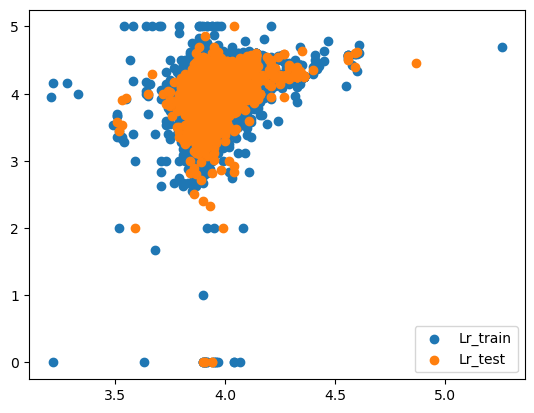

In [176]:
train_pred_lr = grad_LinReg_Mod.predict(X_train).round(2)
test_pred_lr = grad_LinReg_Mod.predict(X_test).round(2)
plt.scatter(train_pred_lr,y_train , label='Lr_train')
plt.scatter(test_pred_lr, y_test, label='Lr_test')
plt.legend()
plt.show()

## 5.A2 Ridge Regression

In [177]:
# Initialize the LinearRegression  model 
ridge_model = Ridge()

# Defining hyper-parameter
parameters = {'alpha': [0.1, 1, 10]}

# Initialize GridSearchCV
grad_ridgeReg = GridSearchCV(ridge_model, {'alpha': [0.1, 1, 10]}, cv=10, refit=True)

# Fit the model
grad_ridgeReg.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(), param_grid={'alpha': [0.1, 1, 10]})

In [178]:
#Predict the Target Values with Ridge Regression
y_pred_ridgeReg = grad_ridgeReg.predict(X_test).round(2)

In [179]:
# Evalute the performance Ridge Regression
r2_ridgeReg = r2_score(y_test, y_pred_ridgeReg) * 100 
MSE_ridgeReg = mean_squared_error(y_test,y_pred_ridgeReg )
RMSE_ridgeReg= np.sqrt(MSE_ridgeReg)

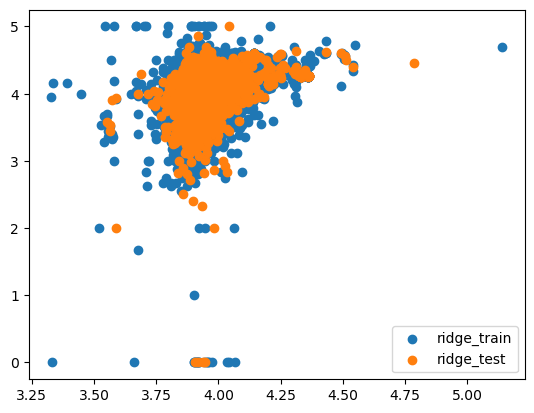

In [180]:
train_pred_ridge = grad_ridgeReg.predict(X_train)
test_pred_ridge = grad_ridgeReg.predict(X_test)
plt.scatter(train_pred_ridge,y_train , label='ridge_train')
plt.scatter(test_pred_ridge, y_test, label='ridge_test')
plt.legend()
plt.show()

## 5.A3 Decision Tree Regression

In [181]:
# Initialize the Decision Tree Regression model 
dt_model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4))

# Defining hyper-parameter
params_ada =  {'learning_rate': [0.005, 0.01, 0.015],'n_estimators': [140, 150, 160]}

# Initialize GridSearchCV
grad_Ada_DtReg = GridSearchCV(dt_model, params_ada, cv=10, refit=True)

# Fit the model
grad_Ada_DtReg.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=4)),
             param_grid={'learning_rate': [0.005, 0.01, 0.015],
                         'n_estimators': [140, 150, 160]})

In [182]:
#Predict the Target Values with Decision Tree Regression
y_pred_DtReg = grad_Ada_DtReg.predict(X_test).round(2)

In [183]:
# Evalute the performance Decision Tree Regression
r2_DtReg = r2_score(y_test, y_pred_DtReg) * 100 
MSE_DtReg = mean_squared_error(y_test,y_pred_DtReg )
RMSE_DtReg= np.sqrt(MSE_DtReg)

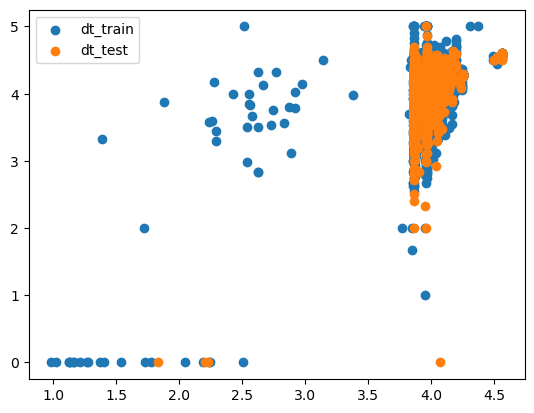

In [184]:
train_pred_dt = grad_Ada_DtReg.predict(X_train)
test_pred_dt = grad_Ada_DtReg.predict(X_test)
plt.scatter(train_pred_dt,y_train , label='dt_train')
plt.scatter(test_pred_dt, y_test, label='dt_test')
plt.legend()
plt.show()

## 5.A4 Random Forest Regression

In [185]:
# Initialize the Random Forest Regression model 
rf_model = RandomForestRegressor()

# Defining hyper-parameter
params_rf = {'n_estimators': [100, 200, 300],'max_depth': [10],'min_samples_leaf': [5]}

# Initialize GridSearchCV
grad_RfReg = GridSearchCV(rf_model, params_rf, cv=10, refit=True)

# Fit the model
grad_RfReg.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10], 'min_samples_leaf': [5],
                         'n_estimators': [100, 200, 300]})

In [186]:
#Predict the Target Values with Random Forest Regression model 
y_pred_RfReg = grad_RfReg.predict(X_test).round(2)

In [187]:
# Evalute the performance Random Forest Regression model 
r2_RfReg = r2_score(y_test, y_pred_RfReg) * 100 
MSE_RfReg = mean_squared_error(y_test,y_pred_RfReg)
RMSE_RfReg= np.sqrt(MSE_RfReg)

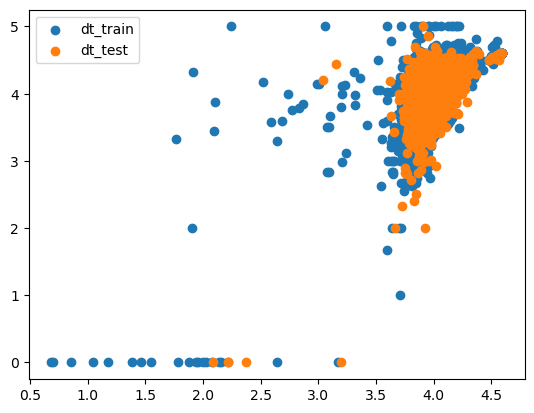

In [188]:
train_pred_rf = grad_RfReg.predict(X_train)
test_pred_rf = grad_RfReg.predict(X_test)
plt.scatter(train_pred_rf,y_train , label='dt_train')
plt.scatter(test_pred_rf, y_test, label='dt_test')
plt.legend()
plt.show()

## 5.A6 Extra Tree Regression

In [189]:
# Initialize Extra Tree Regressor model 
ETR_model = ExtraTreesRegressor()

# Defining hyper-parameter
params_Etr = {'n_estimators': [100, 200, 300],'max_depth': [10],'min_samples_leaf': [5]}

# Initialize GridSearchCV
grad_EtrReg = GridSearchCV(ETR_model, params_Etr, cv=10, refit=True)

# Fit the model
grad_EtrReg.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=ExtraTreesRegressor(),
             param_grid={'max_depth': [10], 'min_samples_leaf': [5],
                         'n_estimators': [100, 200, 300]})

In [190]:
#Predict the Target Values with Extra Tree Regressor model 
y_pred_EtrReg = grad_EtrReg.predict(X_test).round(2)

In [191]:
# Evalute the performance Extra Tree Regressor model  
r2_EtrReg = r2_score(y_test, y_pred_EtrReg) * 100 
MSE_EtrReg = mean_squared_error(y_test,y_pred_EtrReg)
RMSE_EtrReg= np.sqrt(MSE_EtrReg)

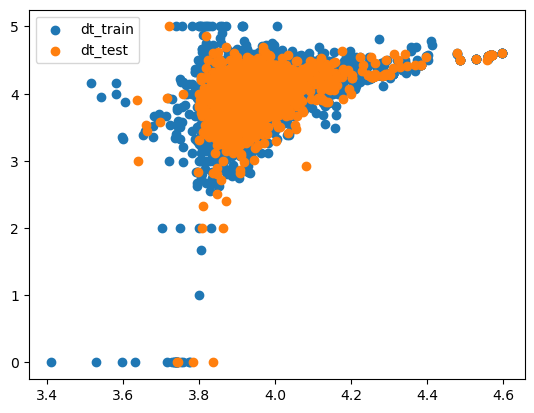

In [192]:
train_pred_ETR = grad_EtrReg.predict(X_train)
test_pred_ETR = grad_EtrReg .predict(X_test)
plt.scatter(train_pred_ETR,y_train , label='dt_train')
plt.scatter(test_pred_ETR, y_test, label='dt_test')
plt.legend()
plt.show()

## 5.A7 Gradient Boosting Regression¶

In [193]:
# Initialize the LinearRegression  model 
GBR_model=GradientBoostingRegressor()

# Defining hyper-parameter
params_gbr = {'n_estimators': [100, 200, 300]}

# Initialize GridSearchCV
grad_GbrReg = GridSearchCV(GBR_model, params_gbr, cv=10, refit=True)

# Fit the model
grad_GbrReg.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(),
             param_grid={'n_estimators': [100, 200, 300]})

In [194]:
#Predict the Target Values with xtra Tree Regressor model 
y_pred_GbrReg = grad_GbrReg.predict(X_test).round(2)

In [195]:
# Evalute the performance Extra Tree Regressor model  
r2_GbrReg = r2_score(y_test,y_pred_GbrReg) * 100 
MSE_GbrReg = mean_squared_error(y_test,y_pred_GbrReg)
RMSE_GbrReg= np.sqrt(MSE_GbrReg)

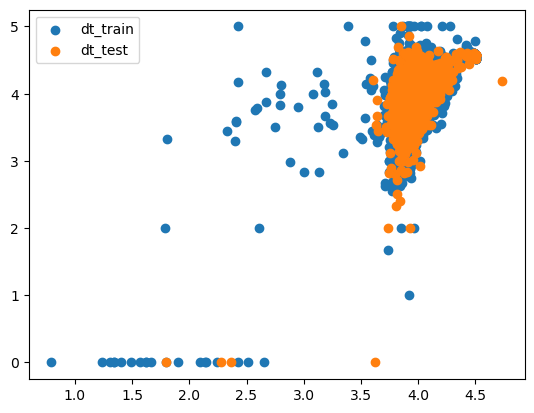

In [196]:
train_pred_GBR = grad_GbrReg.predict(X_train)
test_pred_GBR = grad_GbrReg.predict(X_test)
plt.scatter(train_pred_GBR,y_train , label='dt_train')
plt.scatter(test_pred_GBR, y_test, label='dt_test')
plt.legend()
plt.show()

## 5.A8 Neural network 

In [197]:
# Initialize and train a Multi-Layer Perceptron Regressor
mlp_model = MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42)

In [198]:
#Predict the Target Values with MLP model 
y_pred_mlp = mlp_model.predict(X_test).round(2)

In [199]:
# Evalute the performance Extra MLP model 
r2_mlp = r2_score(y_test,y_pred_mlp) * 100 
MSE_mlp = mean_squared_error(y_test,y_pred_mlp)
RMSE_mlp= np.sqrt(MSE_mlp)

# Evaluating  Regression Models

In [200]:
results = []
results.append(('Linear Regression', r2_LinReg, MSE_LinReg, RMSE_LinReg))
results.append(('Ridge Regression', r2_ridgeReg, MSE_ridgeReg, RMSE_ridgeReg))
results.append(('Decision Tree-AdaBoost Regression', r2_DtReg, MSE_DtReg, RMSE_DtReg))
results.append(('Random Forest Regression', r2_RfReg, MSE_RfReg, RMSE_RfReg))
results.append(('ExtraTrees Regression', r2_EtrReg, MSE_EtrReg, RMSE_EtrReg))
results.append(('Gradient Boosting Regression', r2_GbrReg, MSE_GbrReg, RMSE_GbrReg))
results.append(('MLP Regressor', r2_mlp, MSE_mlp, RMSE_mlp))
# Display results
results_df = pd.DataFrame(results, columns=['Model', 'R2_Score_percent','MSE', 'RMSE'])
results_df.set_index('Model', inplace=True)
print(results_df)


                                   R2_Score_percent       MSE      RMSE
Model                                                                  
Linear Regression                          9.589600  0.109500  0.330900
Ridge Regression                           9.532986  0.109612  0.331077
Decision Tree-AdaBoost Regression         22.473110  0.093933  0.306486
Random Forest Regression                  28.649512  0.086450  0.294024
ExtraTrees Regression                     14.277317  0.103864  0.322279
Gradient Boosting Regression              28.541672  0.086581  0.294246
MLP Regressor                              9.403491  0.109769  0.331314


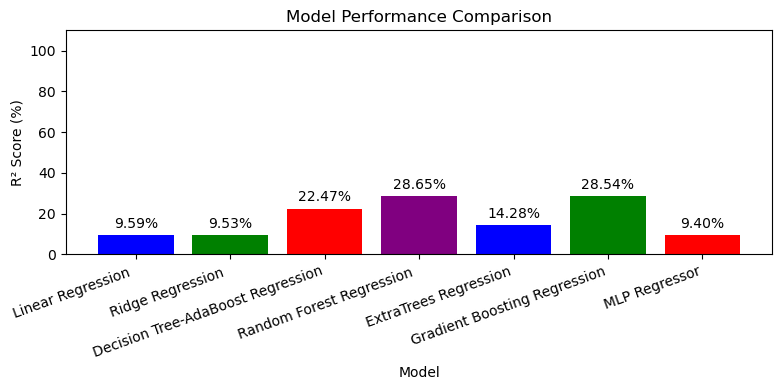

In [201]:
import matplotlib.pyplot as plt

# Model names and their corresponding R² scores
models = ['Linear Regression ', 'Ridge Regression ', 'Decision Tree-AdaBoost Regression', 'Random Forest Regression '
          ,'ExtraTrees Regression','Gradient Boosting Regression', 'MLP Regressor' ]

scores= results_df.R2_Score_percent.values.round(2)

# Create the bar chart
plt.figure(figsize=(8, 4))
bars = plt.bar(models, scores, color=['blue', 'green', 'red', 'purple'])

# Add title and labels
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('R² Score (%)')
plt.ylim(0, 110)  # Extend y-axis for better readability

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 2, f'{yval:.2f}%', ha='center', va='bottom')

# Rotate x-axis labels for better readability
plt.xticks(rotation=20, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

## B. Training the model as Classification

##  Dataset splitting 

In [202]:
books_processed_C=books_processed_1.copy()

In [203]:
books_processed_C.head(1)

,clean_title,average_rating,num_pages,ratings_count,text_reviews_count,publication_year,author_Frequ,publisher_Frequ,average_rating_class,Lang_ENG,...,T_TFIDF_tsubasa reservoir chronicle,T_TFIDF_virginia woolf volume,T_TFIDF_vol fullmetal alchemist,T_TFIDF_vs toya koyo,T_TFIDF_wa petto 11,T_TFIDF_wars light shadow,T_TFIDF_women laura ingalls,T_TFIDF_world war ii,T_TFIDF_writings young women,T_TFIDF_yakitate japan volume
0,harry potter and the half blood prince harry p...,4.57,0.097639,0.455816,0.292696,0.883333,19,21,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [204]:
nan_counts = books_processed_C.isna().sum().sum()
nan_counts

0

In [205]:
# Droping Ttile and average_rating_class column
books_processed_C.drop(['clean_title','average_rating'], axis=1,inplace=True)

In [206]:
from sklearn.model_selection import train_test_split

In [207]:
# the size of the test is 20% and the train is 80%
df_train_C, df_test_C = train_test_split(books_processed_C,test_size = 0.2, random_state=42,stratify=books_processed_C.average_rating_class)

In [208]:
# Total records for dataset
len(books_processed_C)

10287

In [209]:
# Total records for training the model
len(df_train_C)

8229

In [210]:
# Total records for testing the model
len(df_test_C)

2058

In [211]:
# the size of the test is 20% and the train is 80%
df_train_C, df_test_C = train_test_split(books_processed_C,test_size = 0.2,random_state=42)

In [212]:
X_train_C = df_train_C.drop(columns=['average_rating_class'])
y_train_C = df_train_C['average_rating_class']

In [213]:
X_train_C =X_train_C .values
X_train_C 

array([[7.29626809e-02, 1.72000315e-03, 3.70232854e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.09748667e-02, 6.09309158e-03, 1.60398876e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.21934501e-02, 5.65504323e-06, 1.06083912e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.33130236e-03, 3.71057837e-04, 1.81403490e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.69611577e-02, 1.74001330e-06, 1.06083912e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.56054836e-02, 4.78503658e-06, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [214]:
y_train_C =y_train_C.values
y_train_C

array([2, 3, 1, ..., 2, 1, 1], dtype=int64)

In [215]:
X_test_C = df_test_C.drop(columns=['average_rating_class'])
y_test_C = df_test_C['average_rating_class']

In [216]:
X_test_C =X_test_C.values
X_test_C

array([[4.41736481e-03, 7.61255820e-04, 4.16909776e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.29093679e-02, 6.12267181e-04, 5.09202779e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.16298553e-01, 2.00971536e-04, 2.97034955e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [5.30083778e-02, 3.48459414e-03, 6.30138440e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.78217822e-02, 2.15979151e-04, 1.12448947e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.63518660e-02, 8.70006651e-07, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [217]:
y_test_C=y_test_C.values
y_test_C

array([1, 1, 0, ..., 2, 2, 2], dtype=int64)

##  5.B1 Logistic Regression

In [218]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score

In [219]:
# here we initialize the model
lr_model = LogisticRegression(random_state=0,max_iter=2000)

In [220]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(lr_model , X=X_train_C, y=y_train_C, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores (accuracy):", cv_scores)
print("Mean accuracy:", cv_scores.mean())

C:\Users\uwicl\anaconda3\envs\boot-3.9\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\uwicl\anaconda3\envs\boot-3.9\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Cross-validation scores (accuracy): [0.55285541 0.55285541 0.54434994 0.53766707 0.56291793]
Mean accuracy: 0.5501291516322151


C:\Users\uwicl\anaconda3\envs\boot-3.9\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [221]:
# here we train the model on the training data
lr_model.fit(X_train_C,y_train_C)

C:\Users\uwicl\anaconda3\envs\boot-3.9\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=2000, random_state=0)

In [222]:
y_test_predicted_lr = lr_model.predict(X_test_C)

In [223]:
(y_test_predicted_lr == y_test_C).sum()/len(y_test_C)

0.565597667638484

In [224]:
print(np.unique(y_test_C))
print(np.unique(y_test_predicted_lr))

[0 1 2 3 4]
[0 1 2 3]


In [225]:
cf = pd.DataFrame(columns=["y_test_0","y_test_1","y_test_2","y_test_3","y_test_4"],
                  index=["y_pred_0","y_pred_1","y_pred_2","y_pred_3","y_pred_4"])

In [226]:
# Create the confusion matrix
cm = confusion_matrix(y_true=y_test_C, y_pred=y_test_predicted_lr)

In [227]:
cf.loc[:,:] = confusion_matrix(y_true= y_test_C,y_pred= y_test_predicted_lr)

In [228]:
cf

,y_test_0,y_test_1,y_test_2,y_test_3,y_test_4
y_pred_0,11,12,17,0,0
y_pred_1,3,256,575,0,0
y_pred_2,0,133,897,0,0
y_pred_3,0,10,124,0,0
y_pred_4,0,3,16,1,0


In [229]:
cf/len(y_test)

,y_test_0,y_test_1,y_test_2,y_test_3,y_test_4
y_pred_0,0.005345,0.005831,0.00826,0.0,0.0
y_pred_1,0.001458,0.124393,0.279397,0.0,0.0
y_pred_2,0.0,0.064626,0.43586,0.0,0.0
y_pred_3,0.0,0.004859,0.060253,0.0,0.0
y_pred_4,0.0,0.001458,0.007775,0.000486,0.0


In [230]:
report =classification_report(y_true=y_test_C, y_pred=y_test_predicted_lr)

C:\Users\uwicl\anaconda3\envs\boot-3.9\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\uwicl\anaconda3\envs\boot-3.9\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\uwicl\anaconda3\envs\boot-3.9\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [231]:
print(report)

              precision    recall  f1-score   support

           0       0.79      0.28      0.41        40
           1       0.62      0.31      0.41       834
           2       0.55      0.87      0.67      1030
           3       0.00      0.00      0.00       134
           4       0.00      0.00      0.00        20

    accuracy                           0.57      2058
   macro avg       0.39      0.29      0.30      2058
weighted avg       0.54      0.57      0.51      2058



In [232]:
# Now compare the actual output values for y_test with the predicted values.
defaulter_decision_test  = y_test_predicted_lr
df_pred = pd.DataFrame()

df_pred['predicted'] = defaulter_decision_test.astype(float)
df_pred['actual'] = y_test_C
df_pred['diff'] = df_pred['actual'] - df_pred['predicted']

display(df_pred.round(2))

,predicted,actual,diff
0,2.0,1,-1.0
1,1.0,1,0.0
2,1.0,0,-1.0
3,2.0,2,0.0
4,2.0,2,0.0
...,...,...,...
2053,2.0,1,-1.0
2054,2.0,2,0.0
2055,2.0,2,0.0
2056,2.0,2,0.0


## 5.B2 MLPClassifier

In [233]:
from sklearn.neural_network import MLPClassifier

In [234]:
# try a new classifier: Multi-Layer Perceptron classifier
nn_model = MLPClassifier(hidden_layer_sizes=(20,10),max_iter=1000)

In [235]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(nn_model, X=X_train_C, y=y_train_C, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores (accuracy):", cv_scores)
print("Mean accuracy:", cv_scores.mean())

Cross-validation scores (accuracy): [0.53888214 0.55042527 0.54799514 0.52490887 0.55258359]
Mean accuracy: 0.5429590016508659


In [236]:
nn_model.fit(X_train_C,y_train_C)

MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000)

In [237]:
y_test_predicted_nn = nn_model.predict(X_test_C)

In [238]:
report_nn = classification_report(y_pred=y_test_predicted_nn,y_true=y_test_C)

In [239]:
print(report)

              precision    recall  f1-score   support

           0       0.79      0.28      0.41        40
           1       0.62      0.31      0.41       834
           2       0.55      0.87      0.67      1030
           3       0.00      0.00      0.00       134
           4       0.00      0.00      0.00        20

    accuracy                           0.57      2058
   macro avg       0.39      0.29      0.30      2058
weighted avg       0.54      0.57      0.51      2058



## 5.B3 DecisionTreeClassifier

In [240]:
from sklearn.tree import DecisionTreeClassifier

In [241]:
# Try a Decision Tree classifier
dt_model = DecisionTreeClassifier()

In [242]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(dt_model,X=X_train_C, y=y_train_C, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores (accuracy):", cv_scores)
print("Mean accuracy:", cv_scores.mean())

Cross-validation scores (accuracy): [0.51336574 0.4890644  0.49878493 0.4708384  0.49969605]
Mean accuracy: 0.4943499023145361


In [243]:
dt_model.fit(X_train_C,y_train_C)

DecisionTreeClassifier()

In [244]:
y_test_predicted_dt = dt_model.predict(X_test_C)

In [245]:
report_dt = classification_report(y_pred=y_test_predicted_dt,y_true=y_test_C)

In [246]:
print(report_dt)

              precision    recall  f1-score   support

           0       0.32      0.40      0.36        40
           1       0.49      0.53      0.51       834
           2       0.56      0.52      0.54      1030
           3       0.06      0.07      0.06       134
           4       0.12      0.10      0.11        20

    accuracy                           0.49      2058
   macro avg       0.31      0.32      0.32      2058
weighted avg       0.49      0.49      0.49      2058



## 5.B4 RandomForestClassifier

In [247]:
from sklearn.ensemble import RandomForestClassifier

In [248]:
# Try an ensemble classifier: Random Forest
rf_model = RandomForestClassifier()

In [249]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(rf_model,X=X_train_C, y=y_train_C, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores (accuracy):", cv_scores)
print("Mean accuracy:", cv_scores.mean())

Cross-validation scores (accuracy): [0.59781288 0.59356015 0.60935601 0.56865128 0.61155015]
Mean accuracy: 0.5961860935786119


In [250]:
rf_model.fit(X_train_C,y_train_C)

RandomForestClassifier()

In [251]:
y_test_predicted_rf = rf_model.predict(X_test_C)

In [252]:
report_rf = classification_report(y_pred=y_test_predicted_rf,y_true=y_test_C)

In [253]:
print(report_rf)

              precision    recall  f1-score   support

           0       0.76      0.33      0.46        40
           1       0.60      0.53      0.56       834
           2       0.60      0.74      0.66      1030
           3       0.25      0.02      0.04       134
           4       0.67      0.20      0.31        20

    accuracy                           0.60      2058
   macro avg       0.57      0.36      0.41      2058
weighted avg       0.58      0.60      0.57      2058



# Comparing Classification Models

C:\Users\uwicl\anaconda3\envs\boot-3.9\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\uwicl\anaconda3\envs\boot-3.9\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\uwicl\anaconda3\envs\boot-3.9\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

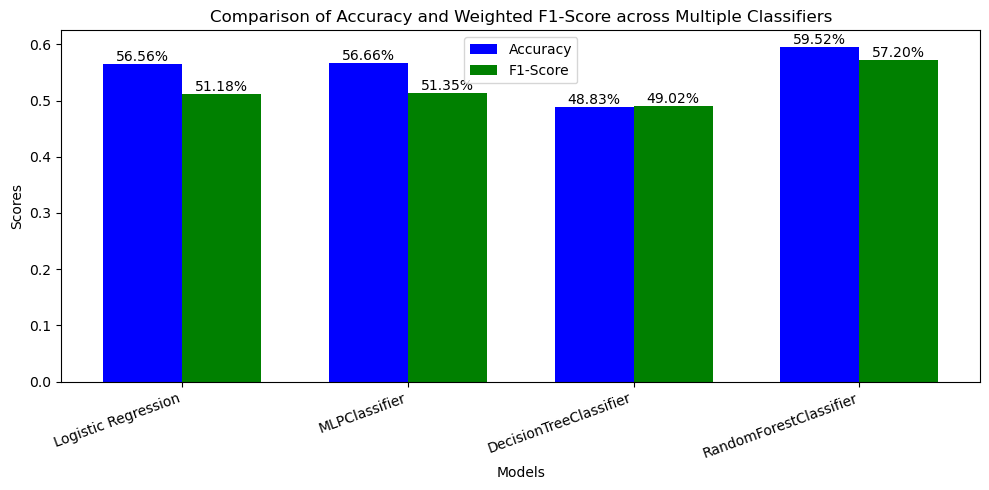

In [254]:
# Generate classification reports for all models
report_lr = classification_report(y_true=y_test_C, y_pred=y_test_predicted_lr, output_dict=True)
report_nn = classification_report(y_true=y_test_C, y_pred=y_test_predicted_nn, output_dict=True)
report_dt = classification_report(y_true=y_test_C, y_pred=y_test_predicted_dt, output_dict=True)
report_rf = classification_report(y_true=y_test_C, y_pred=y_test_predicted_rf, output_dict=True)

# Extract Accuracy and Weighted F1-scores
accuracy_lr = report_lr['accuracy']
f1_weighted_lr = report_lr['weighted avg']['f1-score']

accuracy_nn = report_nn['accuracy']
f1_weighted_nn = report_nn['weighted avg']['f1-score']

accuracy_dt = report_dt['accuracy']
f1_weighted_dt = report_dt['weighted avg']['f1-score']

accuracy_rf = report_rf['accuracy']
f1_weighted_rf = report_rf['weighted avg']['f1-score']

# Plot the results
models = ['Logistic Regression', 'MLPClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier']
accuracy_scores = [accuracy_lr, accuracy_nn, accuracy_dt, accuracy_rf]
f1_scores = [f1_weighted_lr, f1_weighted_nn, f1_weighted_dt, f1_weighted_rf]


# Set the width for the bars
bar_width = 0.35
index = np.arange(len(models))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot accuracy scores
bars1 = ax.bar(index, accuracy_scores, bar_width, label='Accuracy', color='b')

# Plot F1 scores next to the accuracy scores
bars2 = ax.bar(index + bar_width, f1_scores, bar_width, label='F1-Score', color='g')

for i in range(len(bars1)):
    ax.text(bars1[i].get_x() + bars1[i].get_width() / 2, bars1[i].get_height(), 
            f'{accuracy_scores[i]:.2%}', ha='center', va='bottom')
    
for i in range(len(bars2)):
    ax.text(bars2[i].get_x() + bars2[i].get_width() / 2, bars2[i].get_height(), 
            f'{f1_scores[i]:.2%}', ha='center', va='bottom')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Accuracy and Weighted F1-Score across Multiple Classifiers')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)

# Add a legend
ax.legend()
plt.xticks(rotation=20, ha='right')

# Show the plot
plt.tight_layout()
plt.show()